In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import behaviour_functions as bhv
from scipy.stats import chi2
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
path = '/Volumes/lab-kohlj/home/shared/people/Irene/sensory_deprivation/mesh/BORIS project/scored/'
IDs = ["BRYB120.5c", "BRYB138.1d", "BRYB138.1e", "BRYC109.5f", "BRYC115.2e", "BRYD69.5g", "BRYD69.5h", "BRYD75.3g"]
times = ["baseline", "day4"]

In [3]:
# initialize dataframe
behaviours = pd.DataFrame(columns = ["ID", "time", "behaviour", "latency", "duration"])

# extract behaviours for each ID and each experimental time point
for ID in IDs:
    for time in times:
        try:
            # get the paths for each file in dataset, read csv files into a dataframe
            file = glob(path + f'{ID}_virgin_{time}_scored*.csv')
            df = pd.read_csv(file[0])
        # ignore missing datapoints
        except IndexError:
            df = pd.DataFrame(columns = df.columns)
            print(f'{ID}_virgin_{time}_scored*.csv')
            continue
        
        # organise behavioural data and calculate latency and duration of behaviours
        behaviours = bhv.organise_behav(df, ID, time, behaviours, 'time')

# turn values in time to categorical and order them
behaviours.time = pd.Categorical(behaviours.time, categories = times, ordered = True)

# save behaviour dataframe as csv",
# behaviours.to_csv('/Users/salgari/Documents/Documents - XJK222YYCT/GitHub/sensitization_behaviour/dataframes/mesh_behaviours_df.csv')

In [4]:
percentages = pd.DataFrame(columns = ["time", "behaviour", "percentage"])

for time in times:
    for behaviour in behaviours.behaviour.unique():
        per_df = behaviours[(behaviours.behaviour == behaviour) & (behaviours.time == time)]
        num = per_df[per_df.duration == 0].shape[0] #animals that did not perform the behaviour
        percent = (per_df.shape[0] - num) / per_df.shape[0]
        
        percentage = {}
        percentage['time'] = time
        percentage['behaviour'] = behaviour
        percentage['percentage'] = percent
        
        percentage = pd.DataFrame(percentage, index = [0])
            
        percentages = pd.concat([percentages, percentage])
        

In [5]:
# manual implementation of mcnemar's test

# If you're only analyzing a single behavior, you don't need FDR correction
# FDR correction is for multiple comparisons to control false discovery rate

def mcnemar_test_manual(data, behaviour="retrieval to nest"):
    """Manually implement McNemar's test for retrieval to nest behavior"""
    # Get the IDs of all mice in the dataset
    all_mice = data['ID'].unique()
    
    # Initialize the 2x2 contingency table counts
    a = 0  # Both timepoints performed behavior
    b = 0  # Baseline performed, day4 not performed 
    c = 0  # Baseline not performed, day4 performed
    d = 0  # Neither timepoint performed behavior
    
    for mouse in all_mice:
        # Get this mouse's data for both timepoints
        baseline_data = data[(data['ID'] == mouse) & 
                           (data['time'] == 'baseline') &
                           (data['behaviour'] == behaviour)]
        
        day4_data = data[(data['ID'] == mouse) & 
                        (data['time'] == 'day4') &
                        (data['behaviour'] == behaviour)]
        
        # Skip if we don't have data for both timepoints
        if len(baseline_data) == 0 or len(day4_data) == 0:
            continue
        
        # Determine if behavior occurred (duration > 0 means it happened)
        baseline_performed = baseline_data['duration'].values[0] > 0
        day4_performed = day4_data['duration'].values[0] > 0
        
        # Update the contingency table
        if baseline_performed and day4_performed:
            a += 1
        elif baseline_performed and not day4_performed:
            b += 1
        elif not baseline_performed and day4_performed:
            c += 1
        else:
            d += 1
    
    # Calculate McNemar's test statistic with continuity correction
    if b + c == 0:
        statistic = 0
        p_value = 1.0
    else:
        # With continuity correction for better approximation
        numerator = abs(b - c) - 1
        if numerator < 0:
            numerator = 0
        statistic = (numerator ** 2) / (b + c)
        
        # Calculate p-value using chi-square with df=1
        p_value = chi2.sf(statistic, df=1)
    
    return {
        'behaviour': behaviour,
        'a': a, 'b': b, 'c': c, 'd': d,
        'n_total': a + b + c + d,
        'statistic': statistic,
        'p_value': p_value
    }

# Run McNemar test only for "retrieval to nest"
behaviour = "retrieval to nest"
result = mcnemar_test_manual(behaviours, behaviour)

# Create a simple summary dictionary for display
summary = {
    'behaviour': result['behaviour'],
    'a': result['a'], 
    'b': result['b'], 
    'c': result['c'], 
    'd': result['d'],
    'n_total': result['n_total'],
    'p_value': f"{result['p_value']:.4f}"
}

# Add significance indicator
p = result['p_value']
summary['significance'] = ('ns' if p > 0.05 else 
                          ('*' if p <= 0.05 and p > 0.01 else 
                           ('**' if p <= 0.01 and p > 0.001 else 
                            ('***' if p <= 0.001 and p > 0.0001 else '****'))))

# Display the summary
print("\nMcNemar Test Results for 'retrieval to nest' (Baseline vs Day 4):")
print("="*100)
for key, value in summary.items():
    print(f"{key}: {value}")
print("="*100)
print("a: Performed at both timepoints")
print("b: Performed at baseline only")
print("c: Performed at day 4 only")
print("d: Did not perform at either timepoint")
print("Significance: ns = not significant, * p≤0.05, ** p≤0.01, *** p≤0.001, **** p≤0.0001")


McNemar Test Results for 'retrieval to nest' (Baseline vs Day 4):
behaviour: retrieval to nest
a: 1
b: 2
c: 0
d: 5
n_total: 8
p_value: 0.4795
significance: ns
a: Performed at both timepoints
b: Performed at baseline only
c: Performed at day 4 only
d: Did not perform at either timepoint
Significance: ns = not significant, * p≤0.05, ** p≤0.01, *** p≤0.001, **** p≤0.0001


In [ ]:
percentages

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/2484982311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


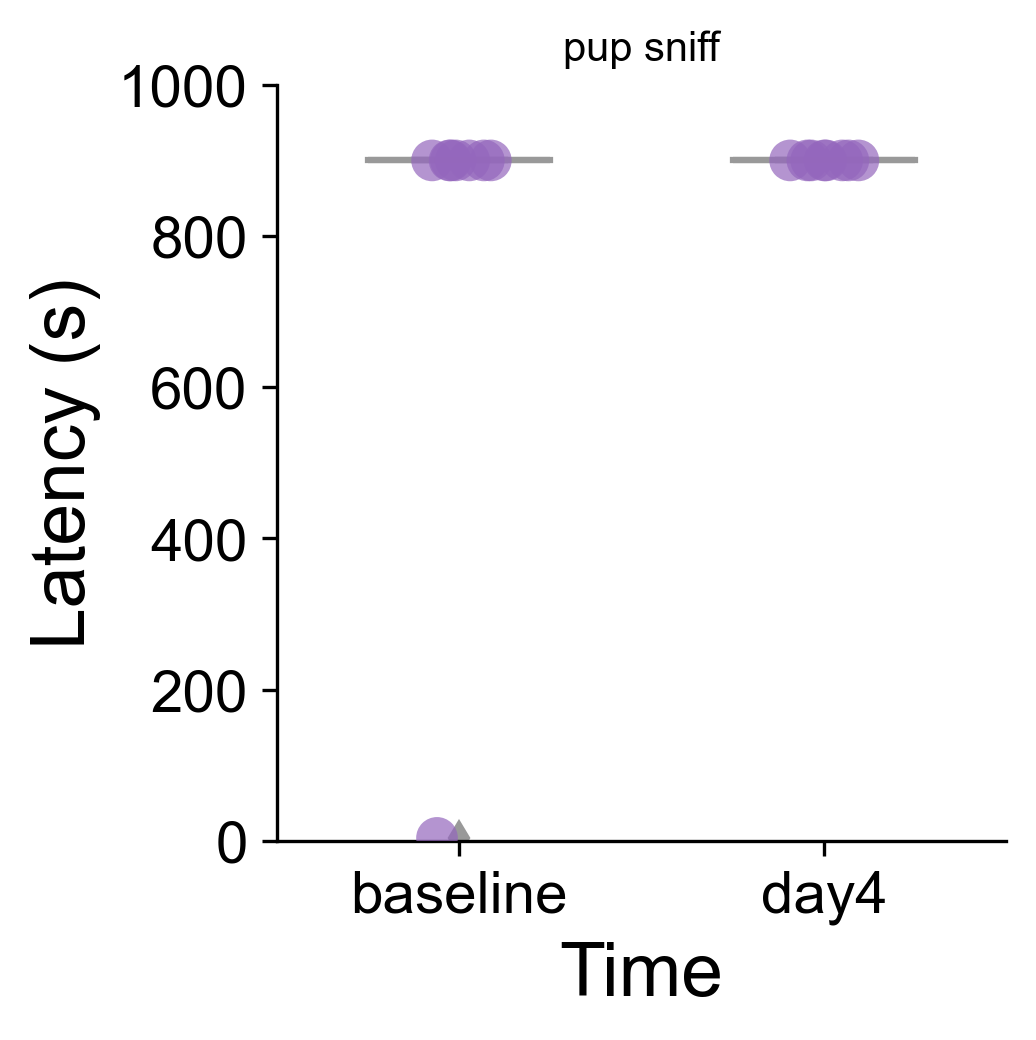

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/2484982311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


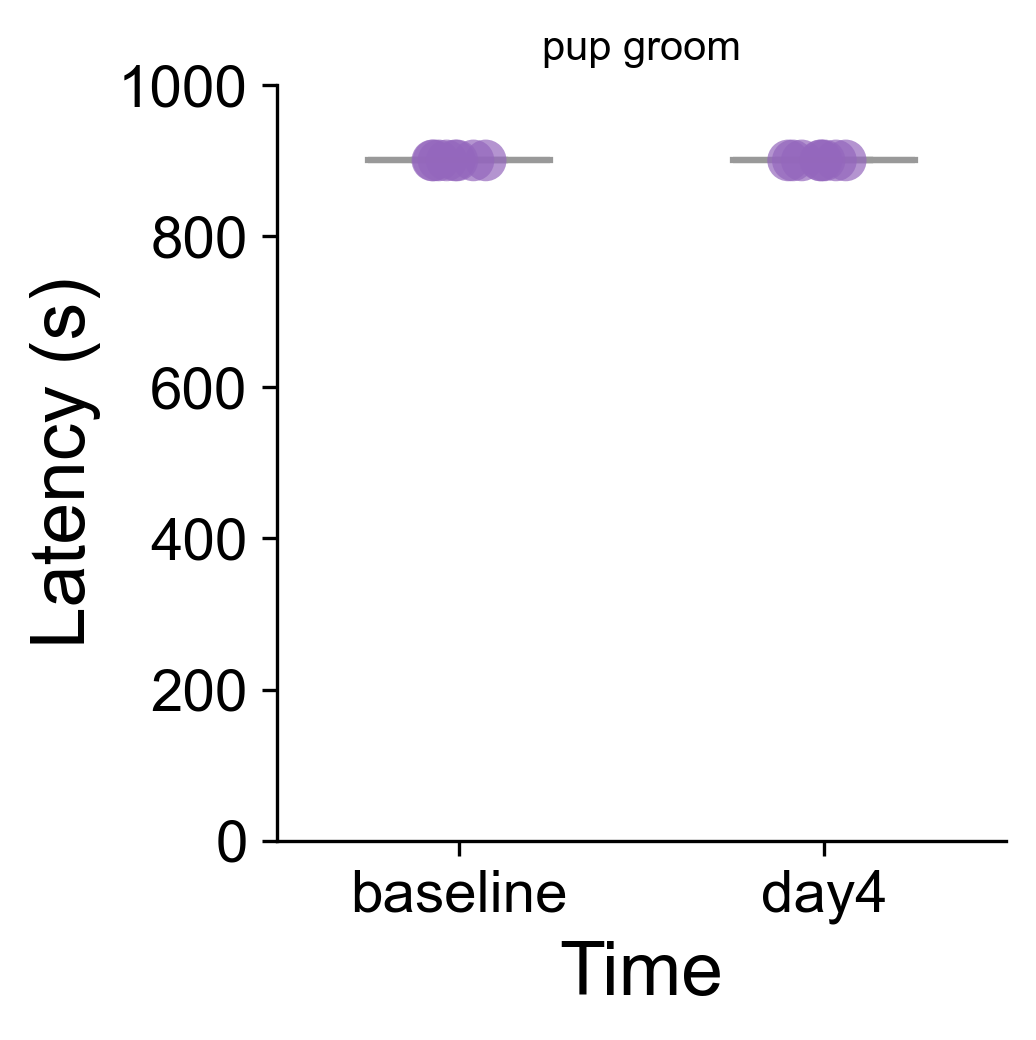

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/2484982311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


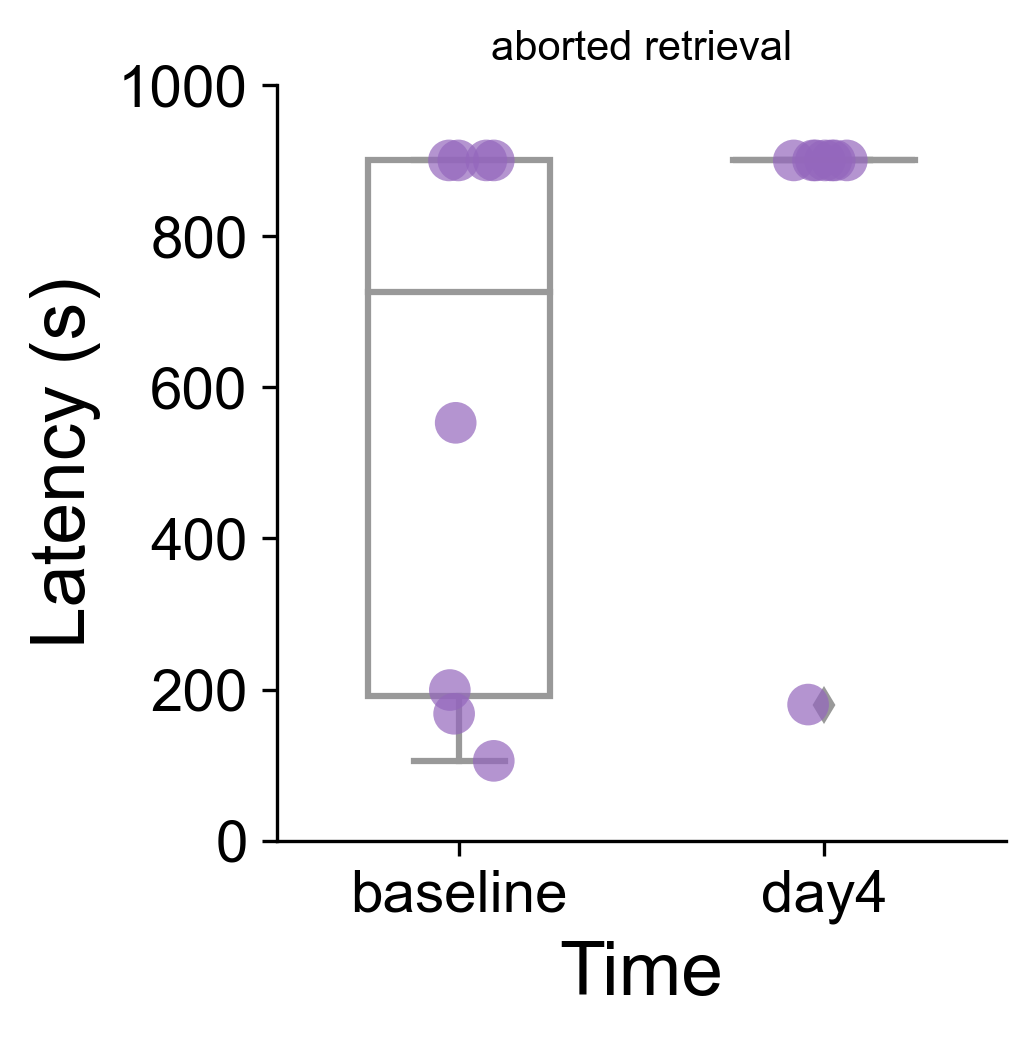

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/2484982311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


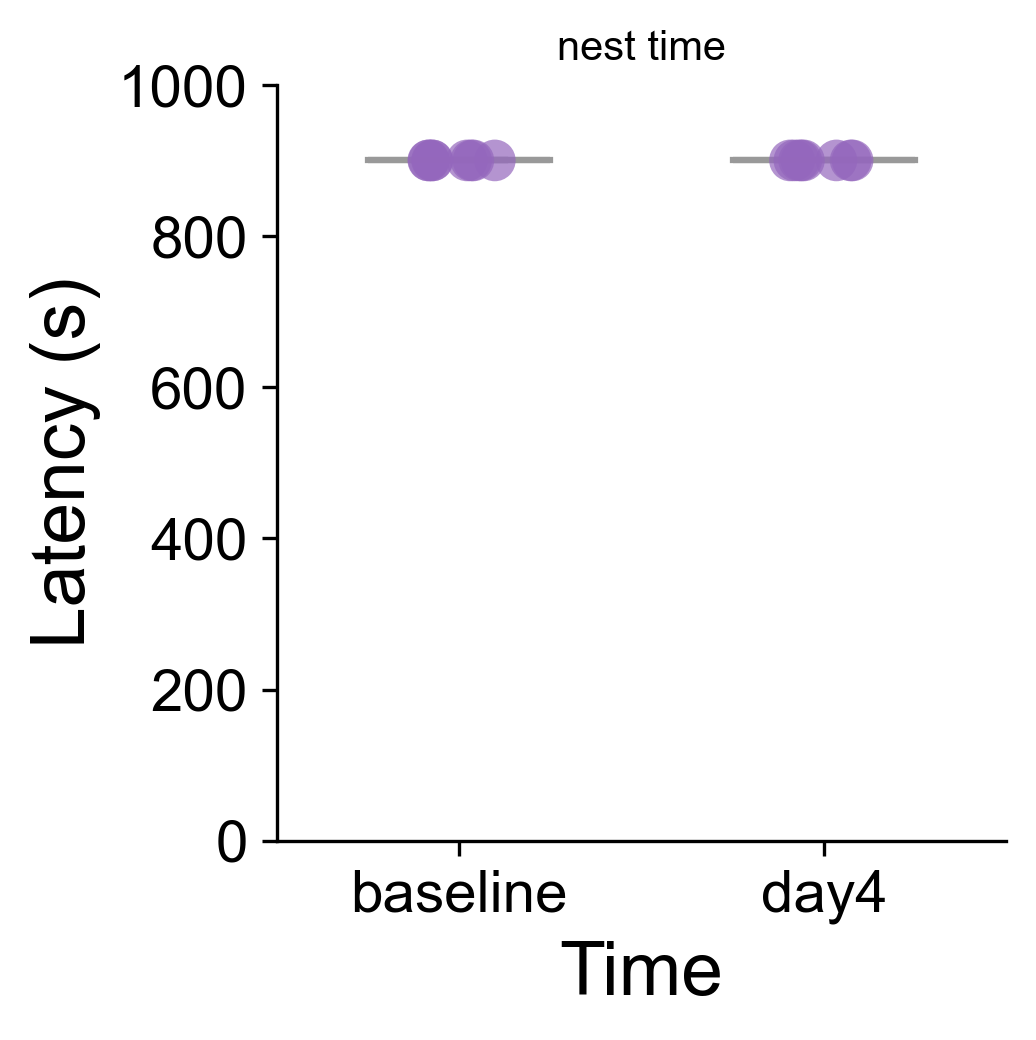

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/2484982311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


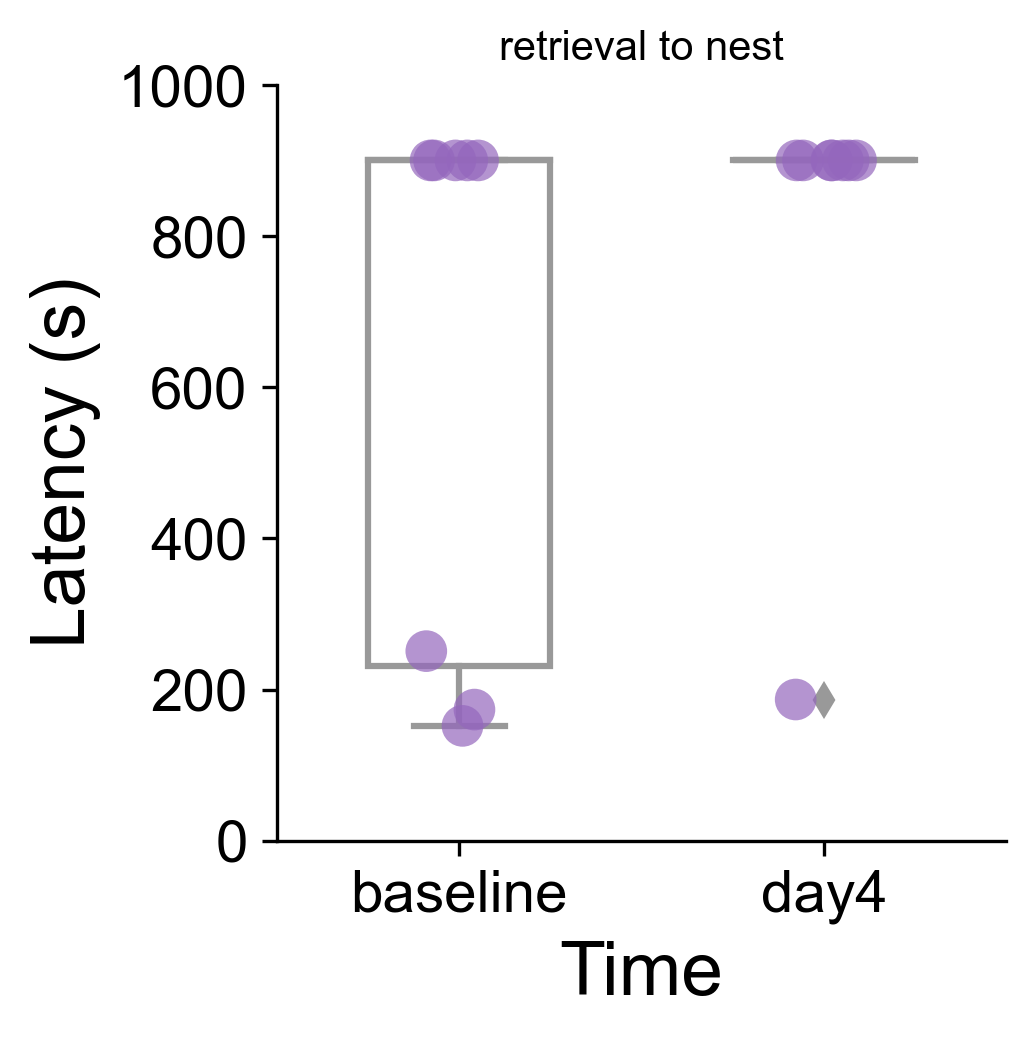

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/2484982311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


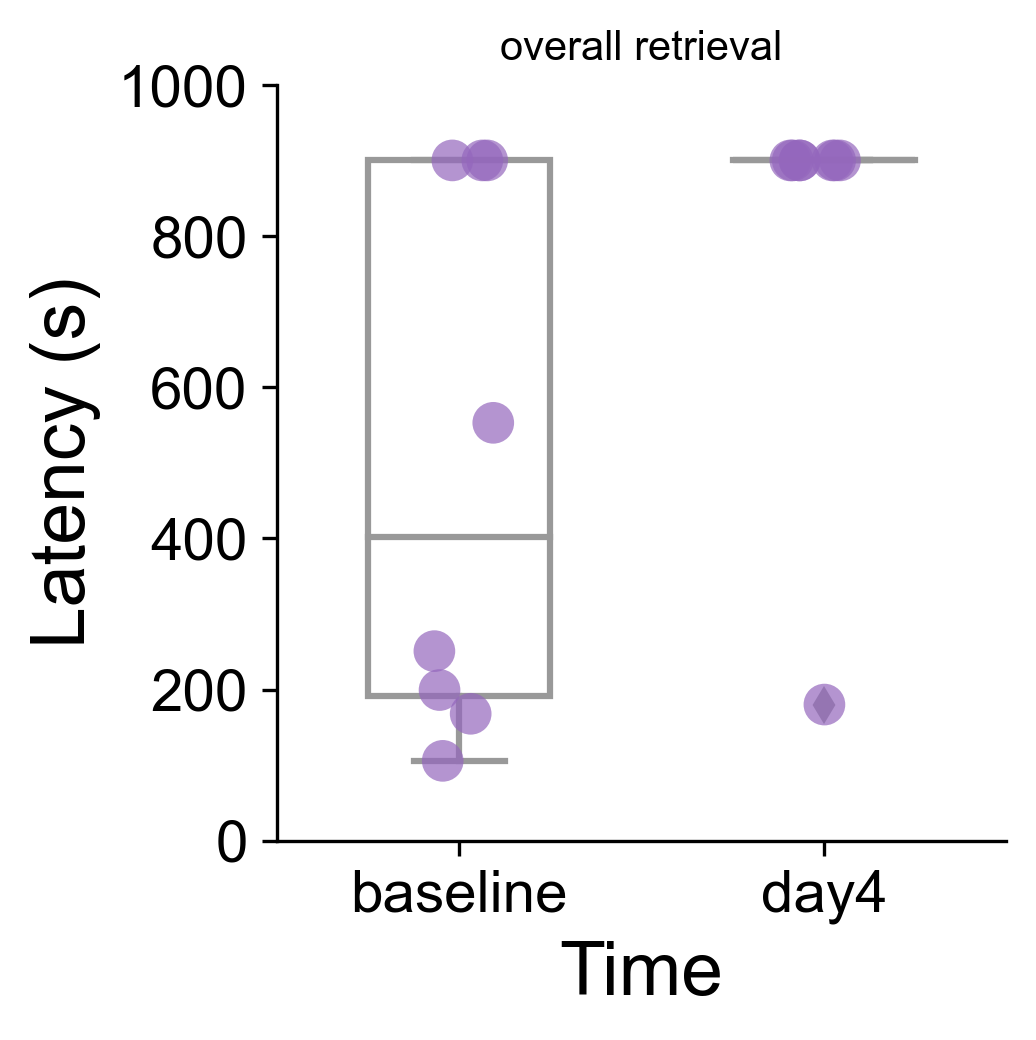

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/2484982311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


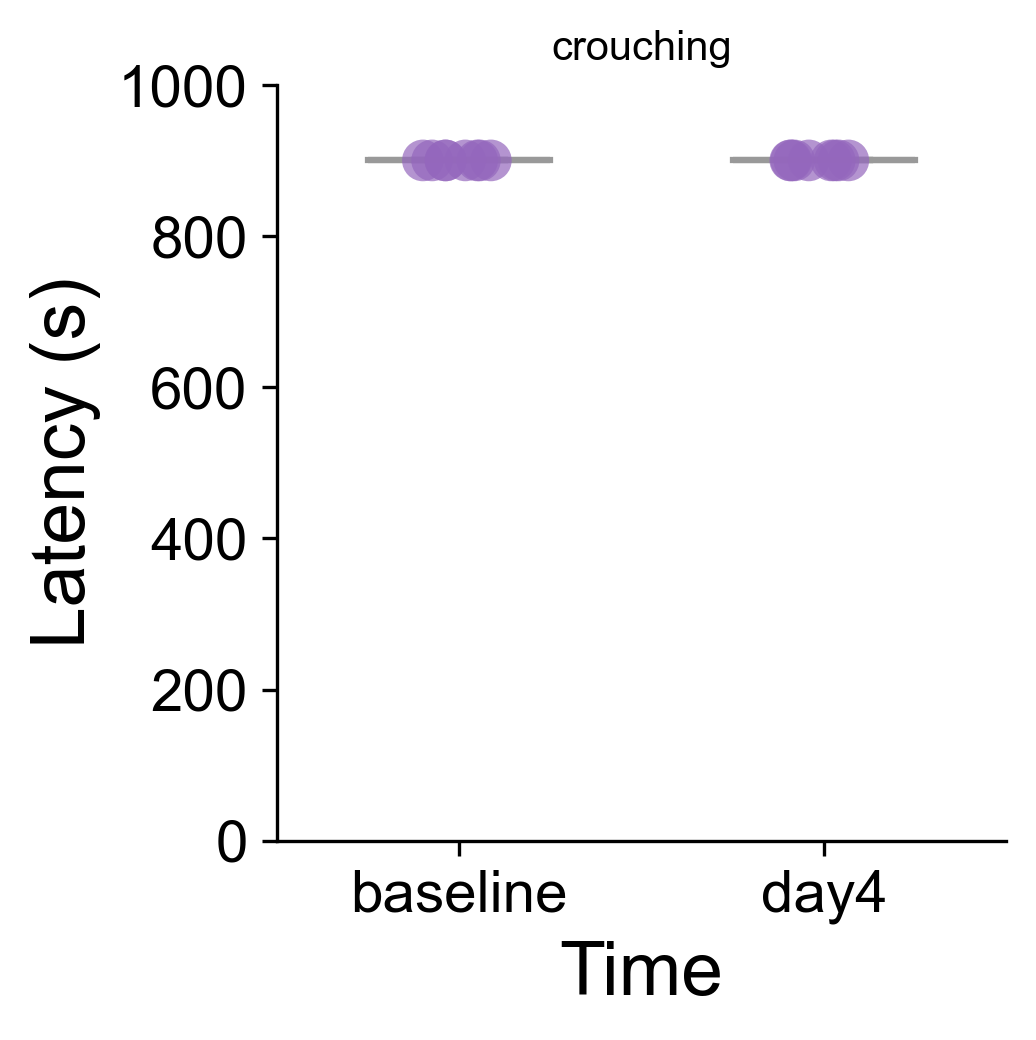

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/2484982311.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


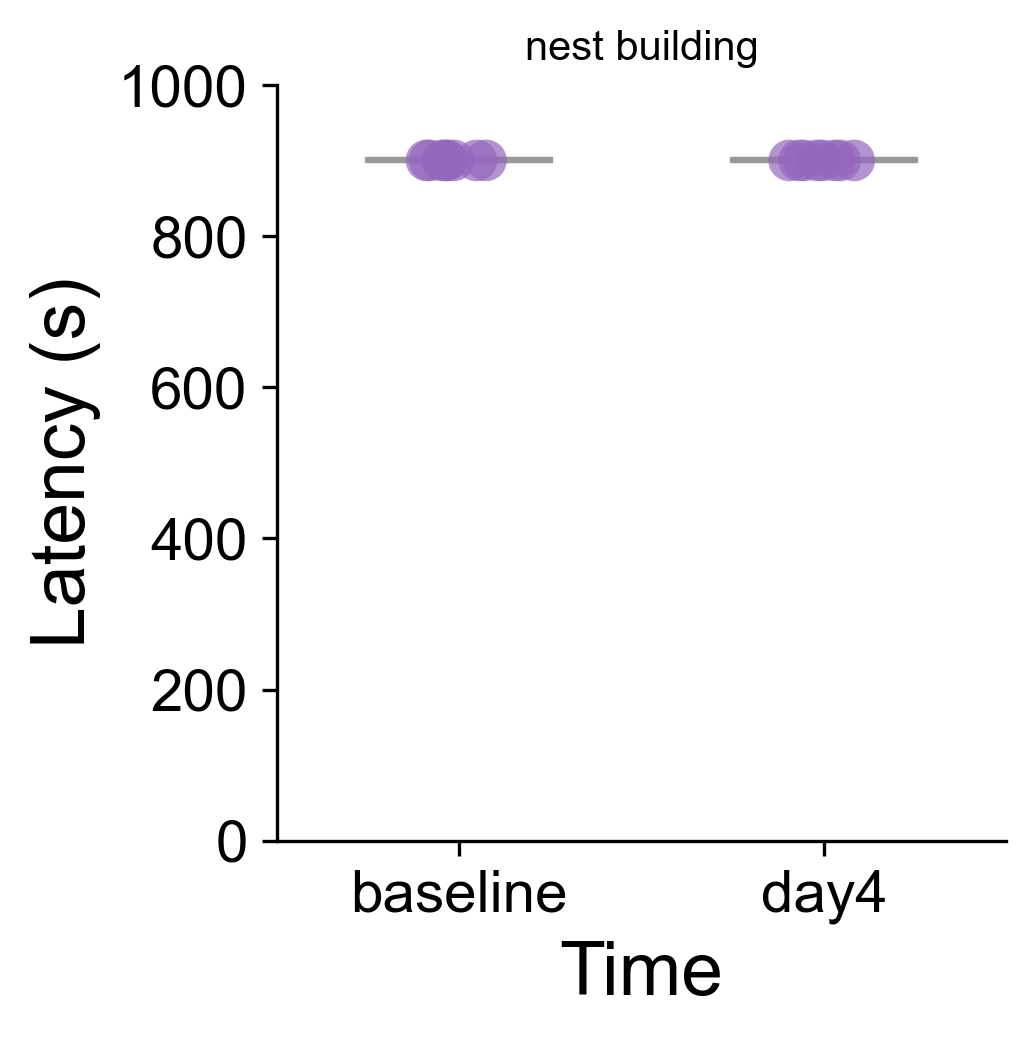

In [16]:


for behaviour in behaviours.behaviour.unique():
    behav_df = behaviours[behaviours.behaviour == behaviour]
    
    behav_df.latency = pd.to_numeric(behav_df.latency)
    # mean = behav_df.groupby(by = 'time').mean().reset_index()
    # st_error = behav_df.groupby(by = 'time').std()/np.sqrt(len(behav_df.ID.unique()))
    # st_error = st_error.reset_index()
    
    # model = smf.ols('latency ~ C(time)', data = behav_df).fit()
    # print(sm.stats.anova_lm(model, typ = 2))
    
    # m_comp = pairwise_tukeyhsd(endog=behav_df.latency, groups = behav_df.time, alpha = 0.05)
    # print(m_comp._results_table)

    
#     fig, ax = plt.subplots(figsize = [10, 5])
#     fig.tight_layout()
    
#     plt.plot(mean.time, mean.latency, color = 'purple', alpha = 0.7)
#     plt.fill_between(mean.time,  mean.latency + st_error.latency, mean.latency - st_error.latency, 
#                      color = 'purple', alpha = 0.05)
    
#     ax.set_xlim(['baseline', 'day50'])
#     ax.set_ylim([0, 900])
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
#     plt.xticks(fontsize = 12)
#     plt.yticks(fontsize = 12)
    
#     plt.ylabel('Latency (s)', fontsize = 14)
    
#     plt.title(behaviour)
    
#     plt.savefig(f'plots/{behaviour}_latency.jpg', dpi = 300, bbox_inches = 'tight')
#     plt.show()

    
#     fig, ax = plt.subplots(figsize = [10, 5])
#     fig.tight_layout()
    
#     sns.pointplot(mean.time, mean.latency, color = 'purple', alpha = 0.7)
#     # plt.fill_between(mean.time,  mean.latency + st_error.latency, mean.latency - st_error.latency, 
#                      # color = 'purple', alpha = 0.05)
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
#     plt.xticks(fontsize = 12)
#     plt.yticks(fontsize = 12)
    
#     plt.ylabel('Latency (s)', fontsize = 14)
#     plt.title(behaviour)
#     plt.show()
    
    fig, ax = plt.subplots(figsize = [3,3])
    fig.tight_layout()
    sns.boxplot(x='time', y='latency', data = behav_df, color = 'white', width = 0.5)
    sns.stripplot(x = "time", y = "latency", data = behav_df, palette = ['Tab:purple'], alpha = 0.7, size = 10)
    # sns.barplot(x = "time", y = "latency", data = mean, palette = ["purple"], errorbar = "se", alpha = 0.3)
    # sns.lineplot(x = "time", y = "latency", data = behav_df, style = "ID", color = 'grey', alpha = 0.4, size = 7, marker = 'o', markersize=10, markerfacecolor='purple',legend = False)
    ax.set_ylim([0, 1000])
    plt.ylabel('Latency (s)', fontsize = 18)
    plt.xlabel('Time', fontsize = 18)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.title(behaviour)
    sns.despine()
    # plt.savefig(f'plots_mesh/{behaviour}_latency.jpg', dpi = 300, bbox_inches = 'tight')
    plt.show()
    


/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/928491949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


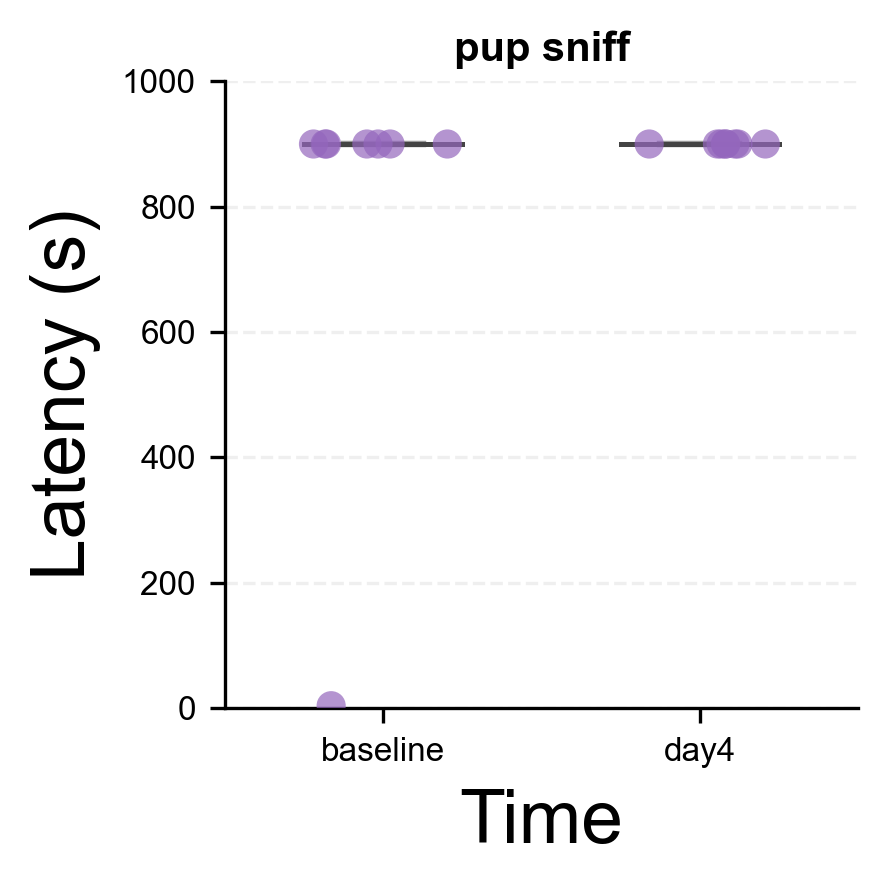

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/928491949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


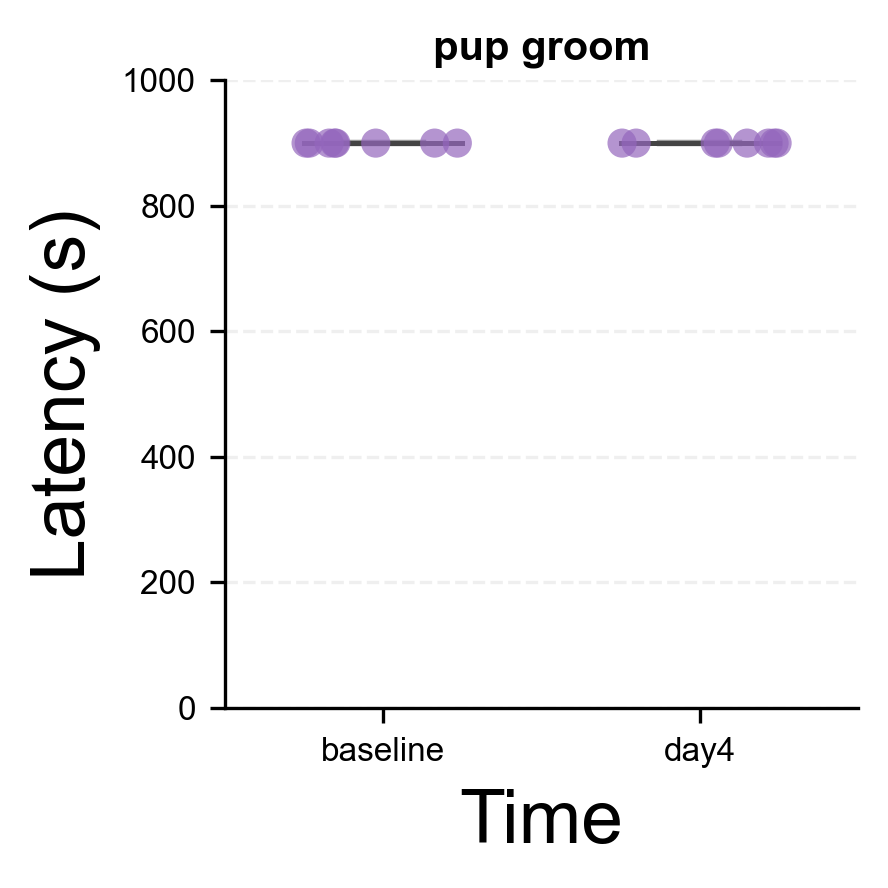

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/928491949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


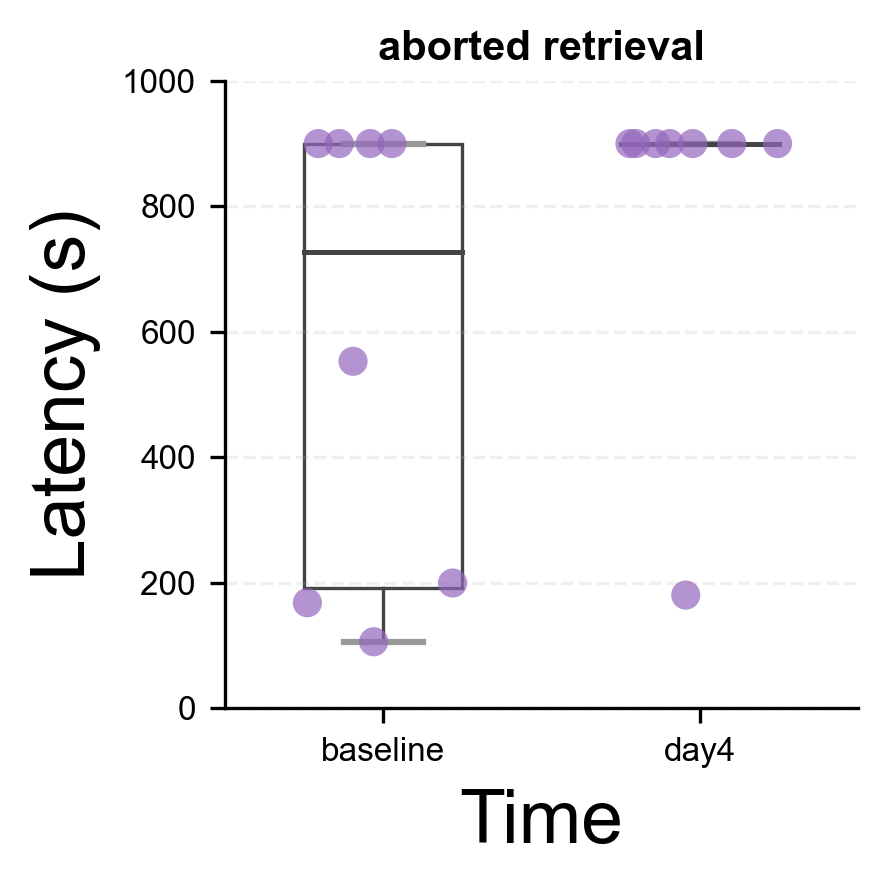

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/928491949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


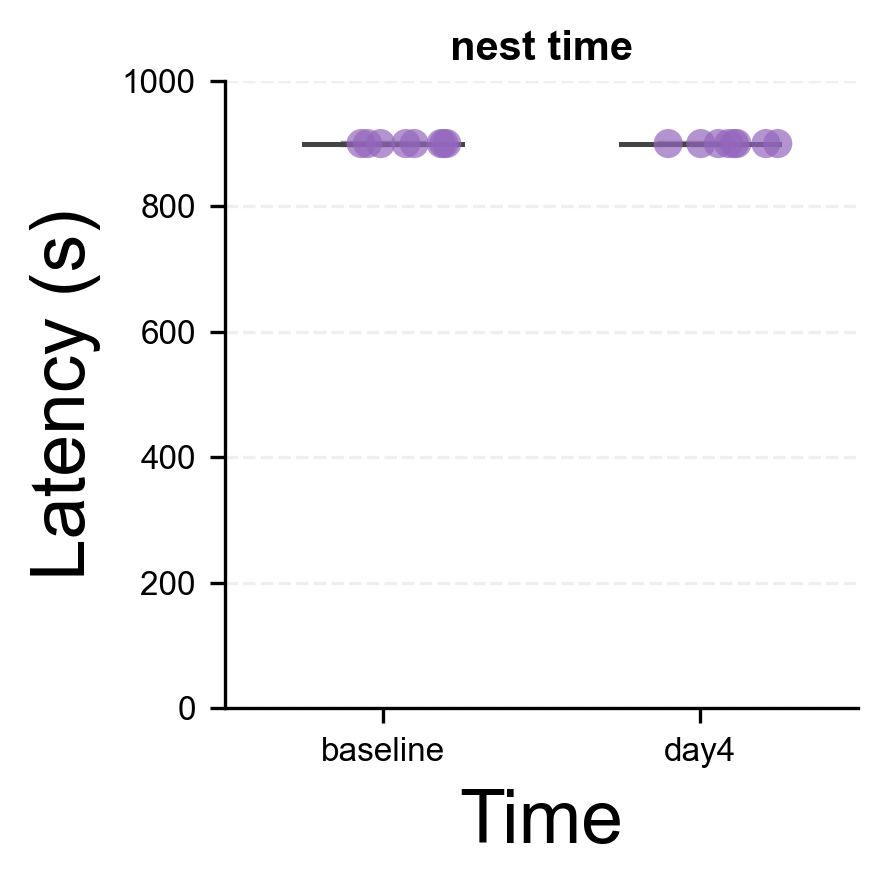

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/928491949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


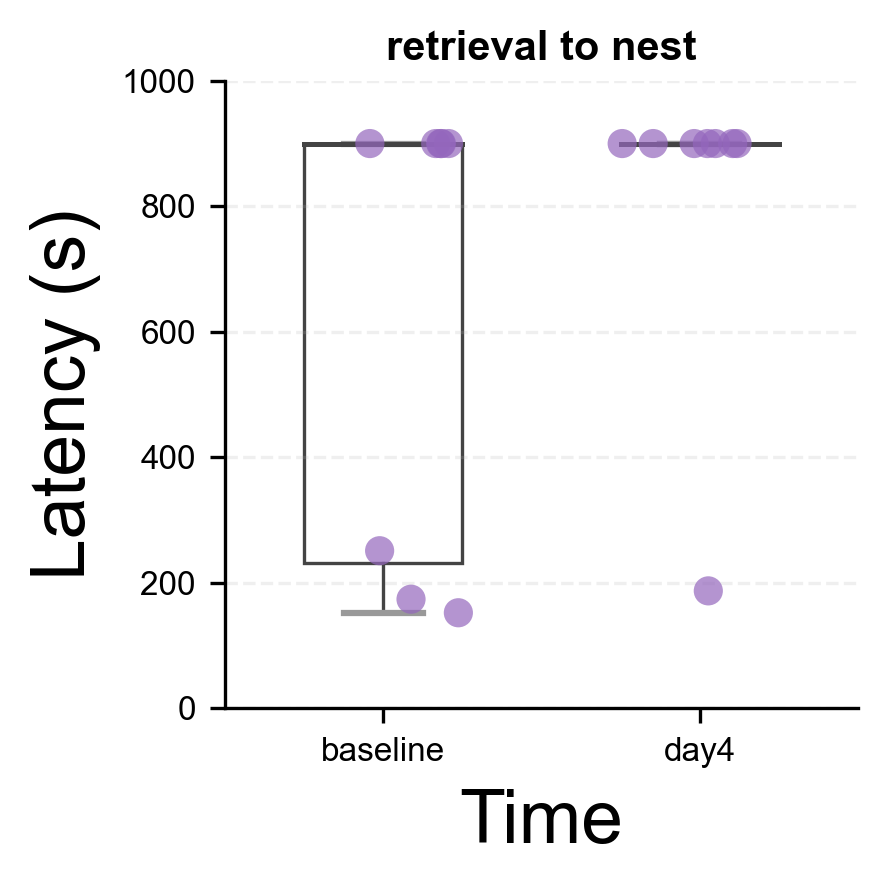

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/928491949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


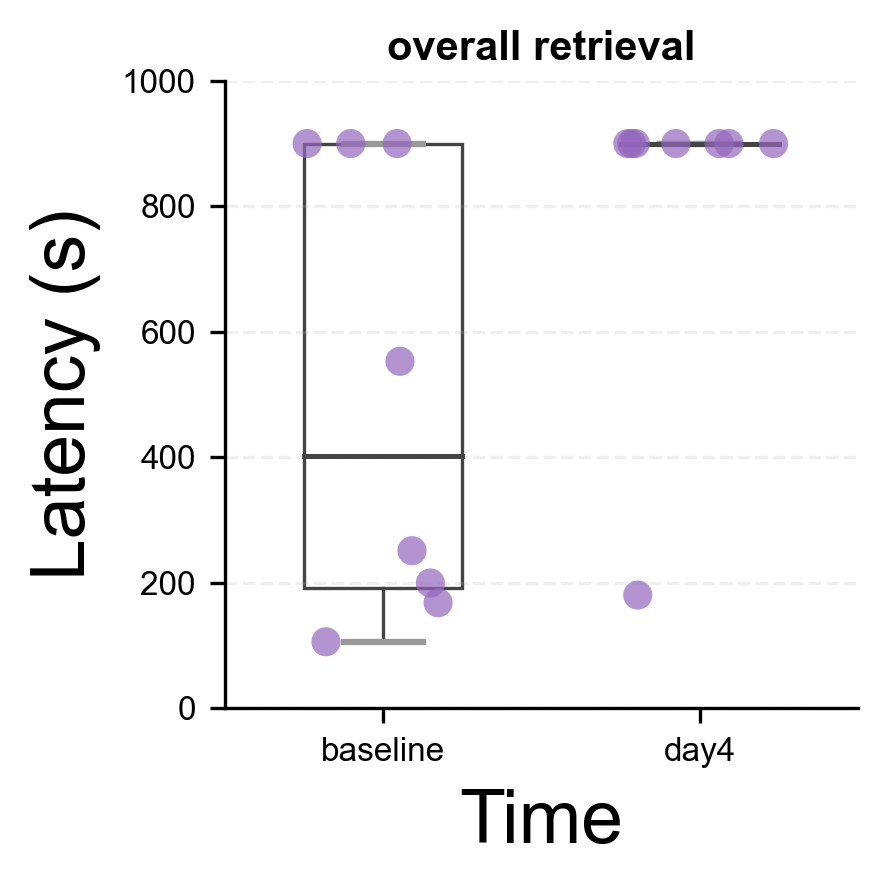

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/928491949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


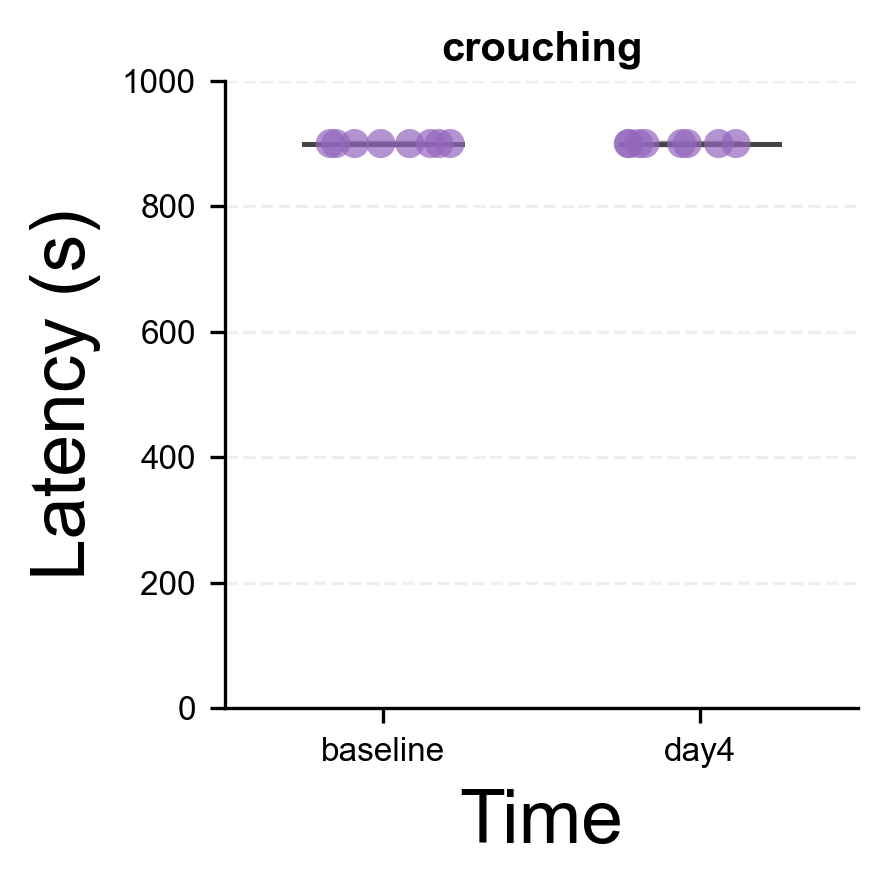

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/928491949.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


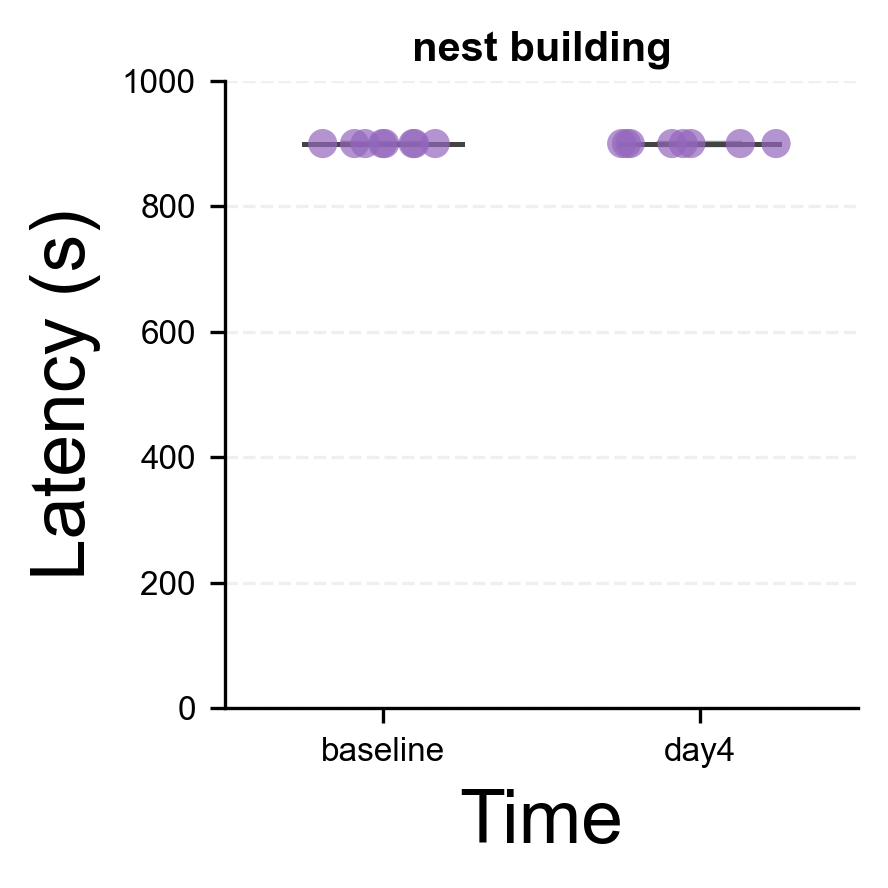

In [23]:
# Set publication-ready style parameters
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,  # Reduced font size for compact plots
    'axes.linewidth': 0.8,  # Thinner axes lines
    'axes.labelsize': 18,  # Smaller label size
    'axes.titlesize': 10,  # Smaller title size
    'xtick.labelsize': 8,  # Smaller tick labels
    'ytick.labelsize': 8,  # Smaller tick labels
    'figure.dpi': 300
})

for behaviour in behaviours.behaviour.unique():
    behav_df = behaviours[behaviours.behaviour == behaviour]
    
    # Convert to numeric if needed
    behav_df.latency = pd.to_numeric(behav_df.latency)
    
    # Create figure with compact size
    fig, ax = plt.subplots(figsize=(3, 3))
    
    # Add a subtle grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    
    # Enhanced boxplot with dark grey edges
    box = sns.boxplot(x='time', y='latency', data=behav_df, 
                     color='white', width=0.5, 
                     boxprops={'edgecolor': '#444444', 'linewidth': 0.8},
                     whiskerprops={'linewidth': 0.8, 'color': '#444444'},
                     medianprops={'color': '#444444', 'linewidth': 1.2},
                     showfliers=False)
    
    # Stripplot with original Tab:purple color and no edge color
    strip = sns.stripplot(x='time', y='latency', data=behav_df, 
                         palette=['Tab:purple'], alpha=0.7, size=7,
                         jitter=0.25, linewidth=0)
    
    # Set y-axis limits
    ax.set_ylim([0, 1000])
    
    # Adjust labels for compact size
    plt.ylabel('Latency (s)', labelpad=5)
    plt.xlabel('Time', labelpad=5)
    
    # Add title with minimal spacing
    plt.title(behaviour, pad=5, fontweight='bold')
    
    # Remove unnecessary spines
    sns.despine()
    
    # Ensure tight layout with minimal padding
    fig.tight_layout()
    
    # Save figures in publication-ready formats
    plt.savefig(f'plots_mesh/{behaviour}_latency.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'plots_mesh/{behaviour}_latency.png', dpi=600, bbox_inches='tight')
    
    plt.show()

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/4028423617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


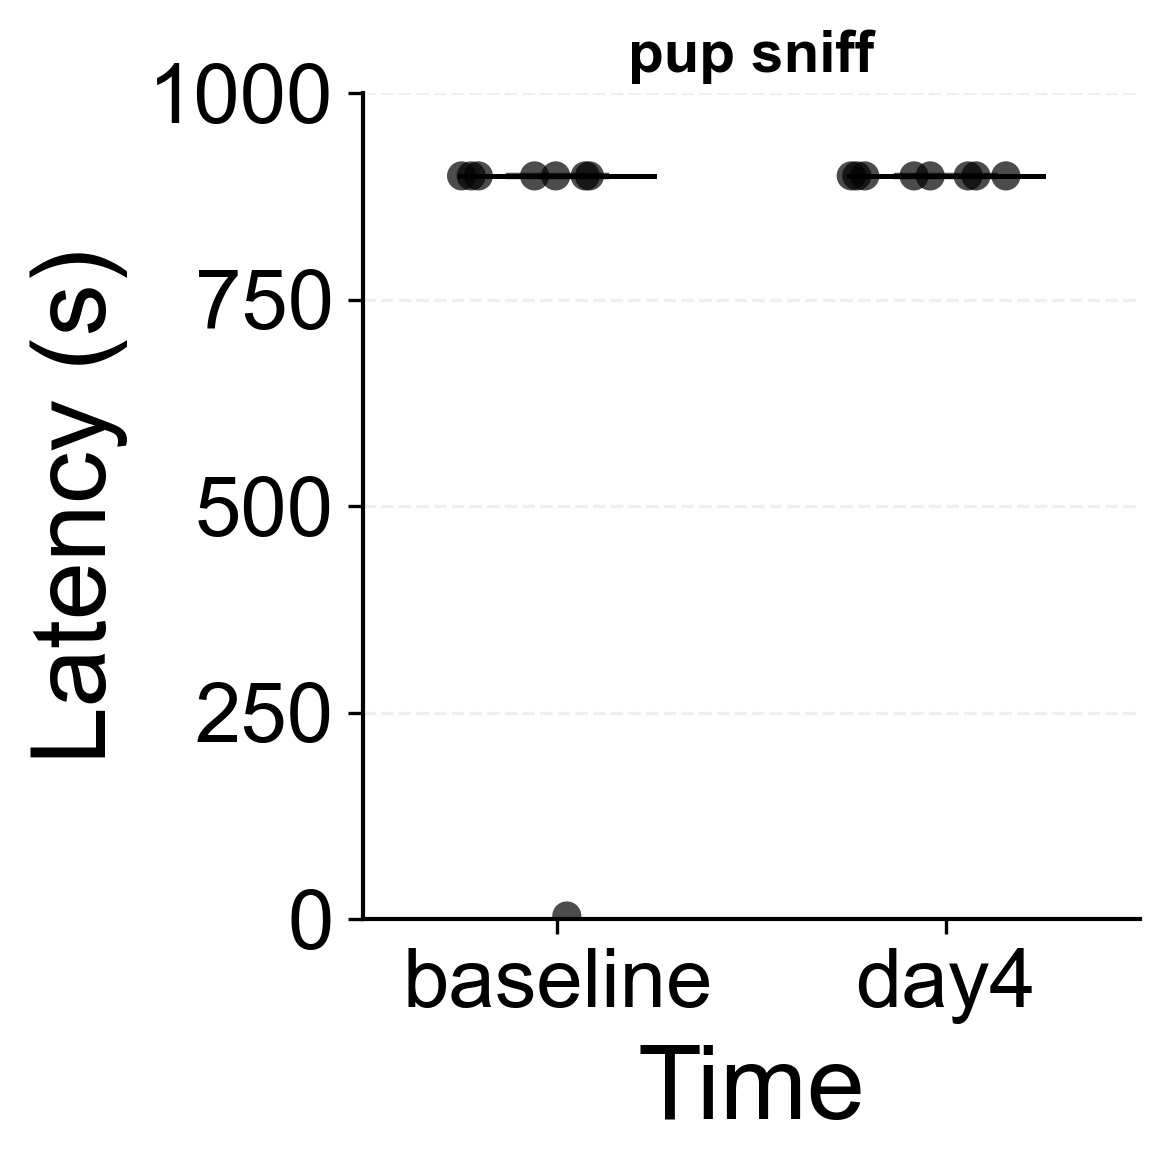

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/4028423617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


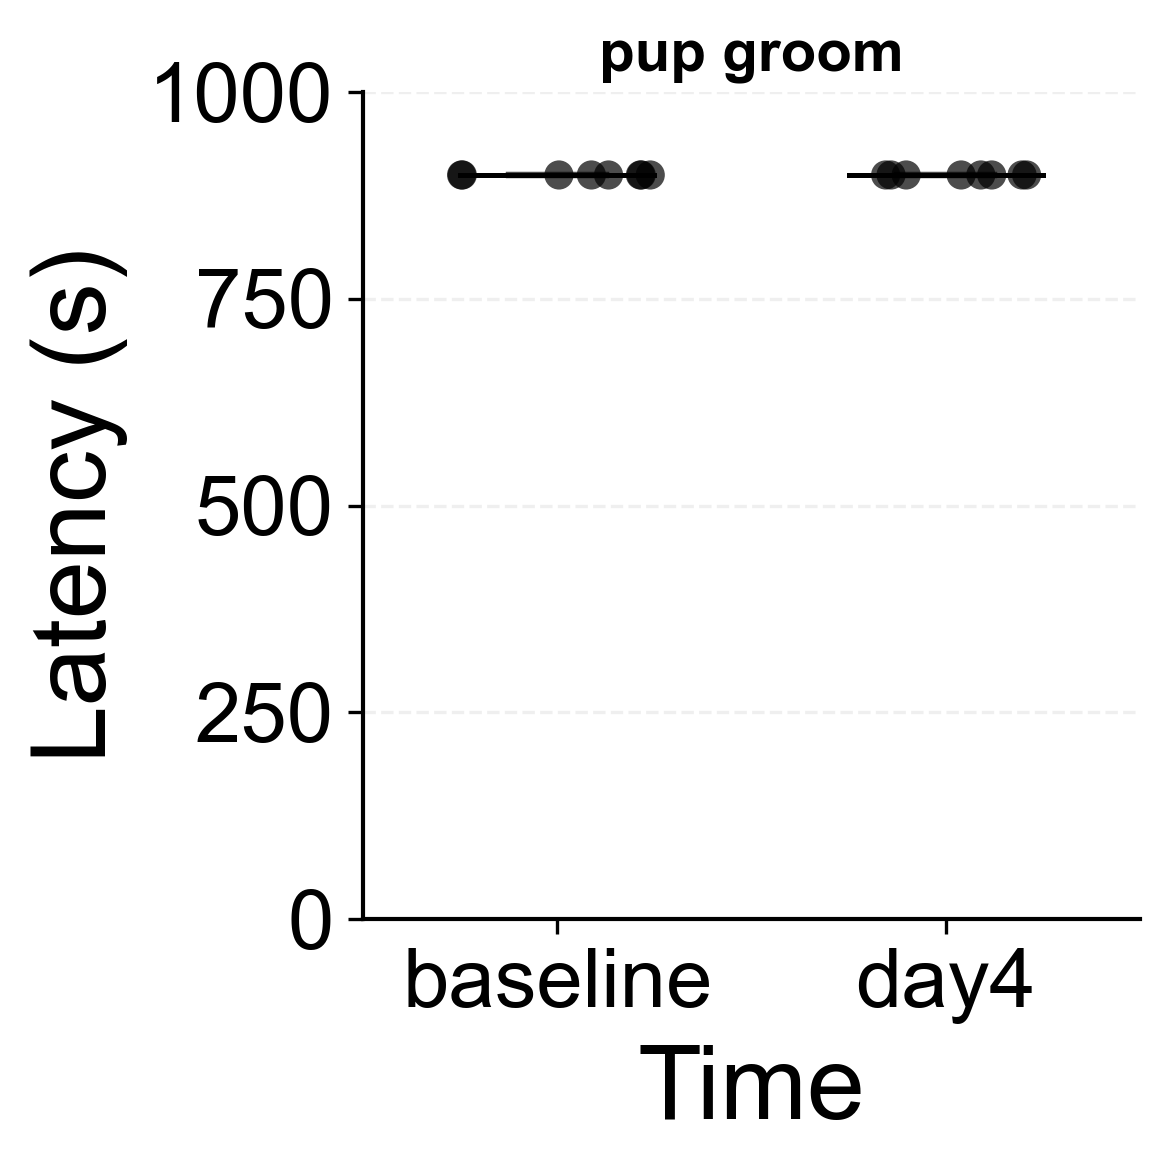

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/4028423617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


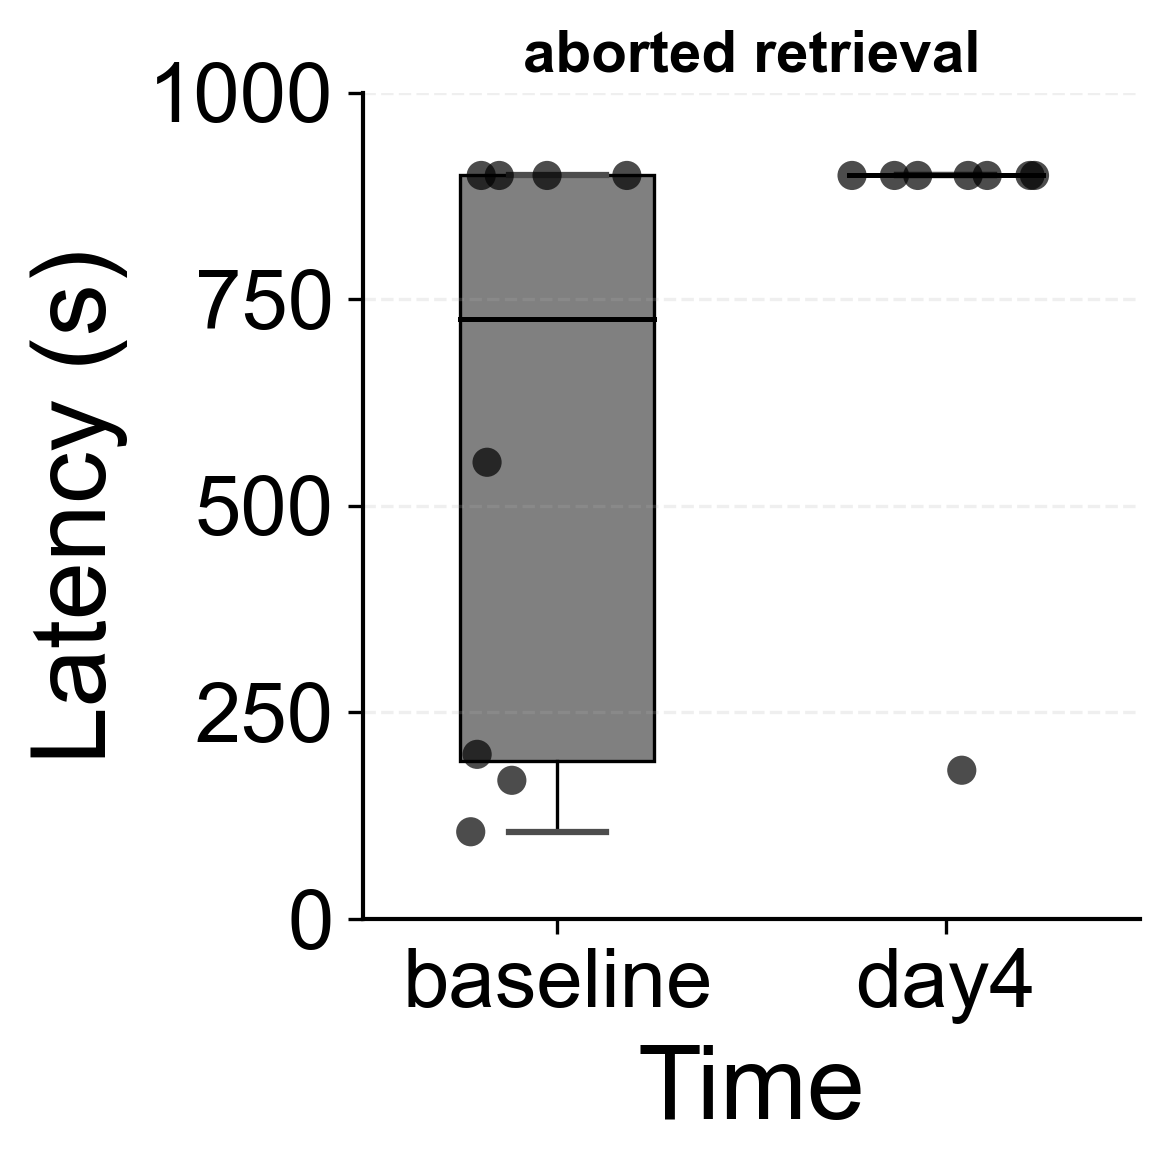

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/4028423617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


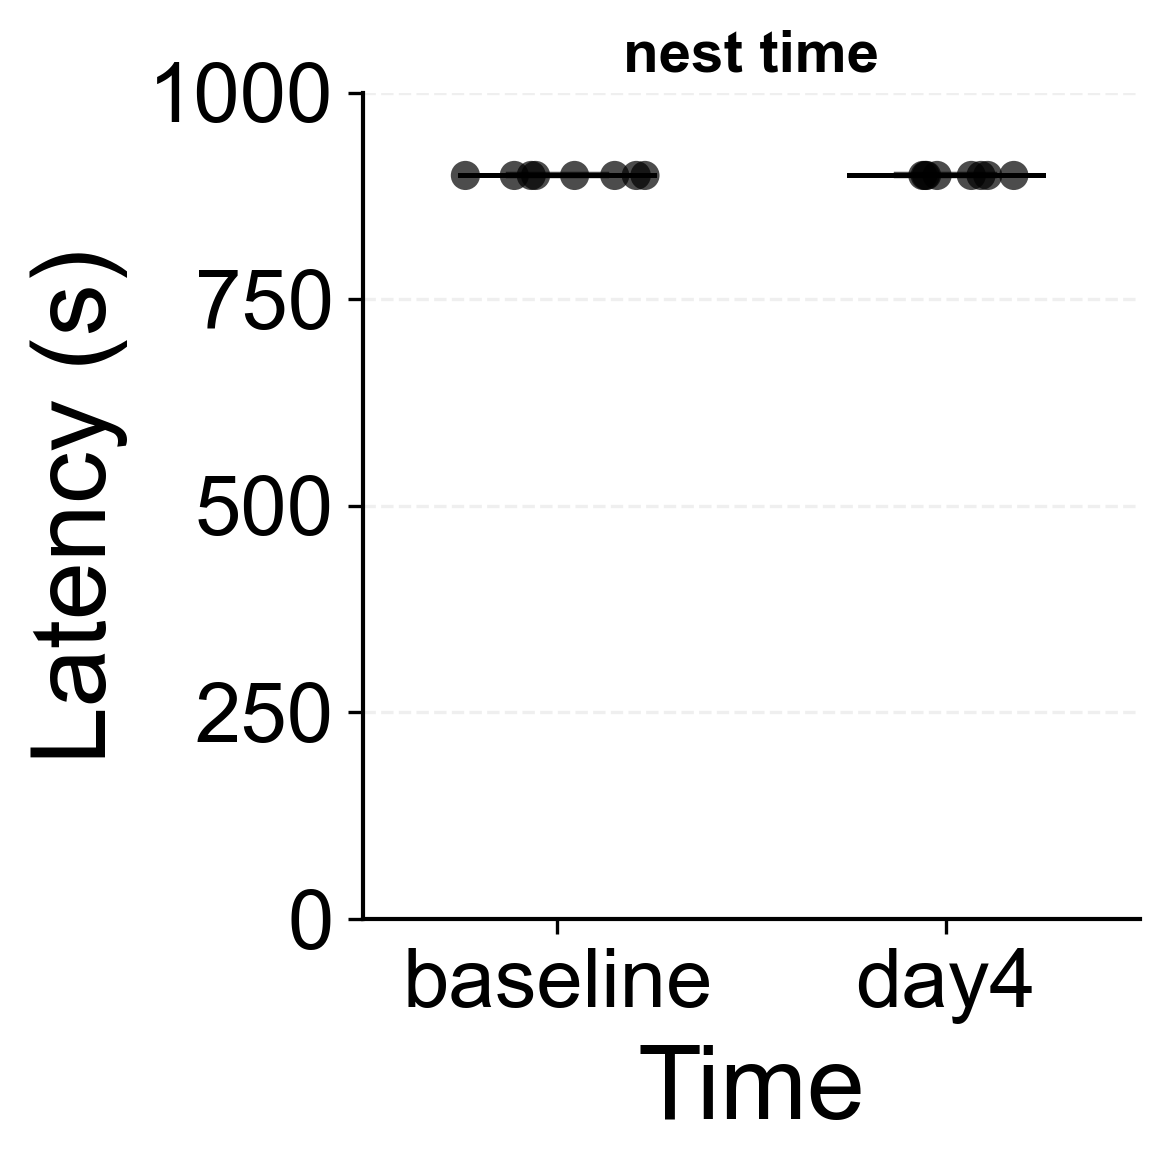

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/4028423617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


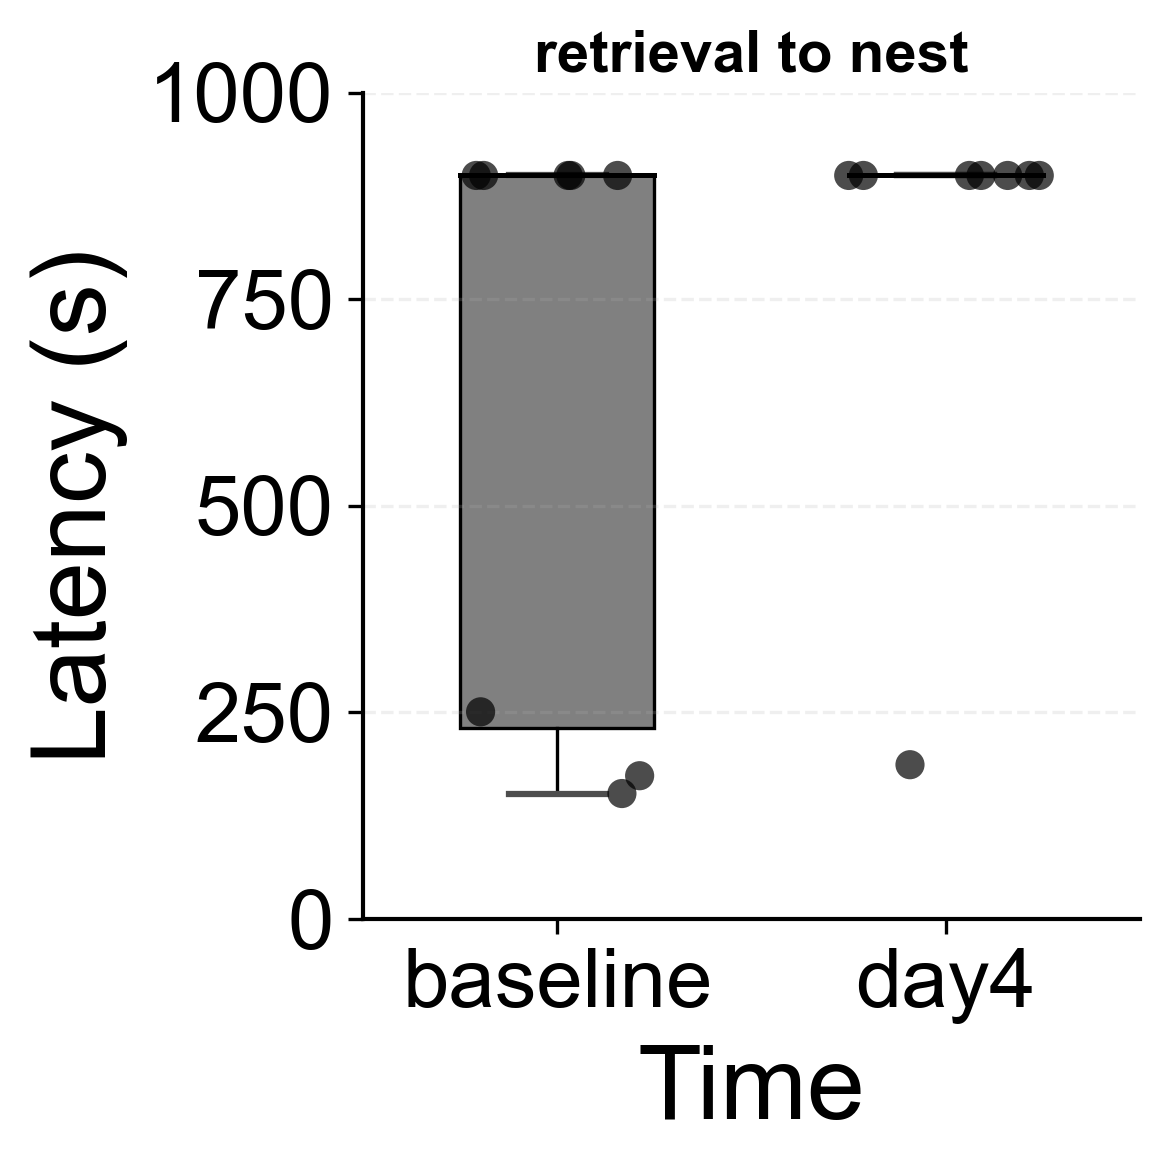

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/4028423617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


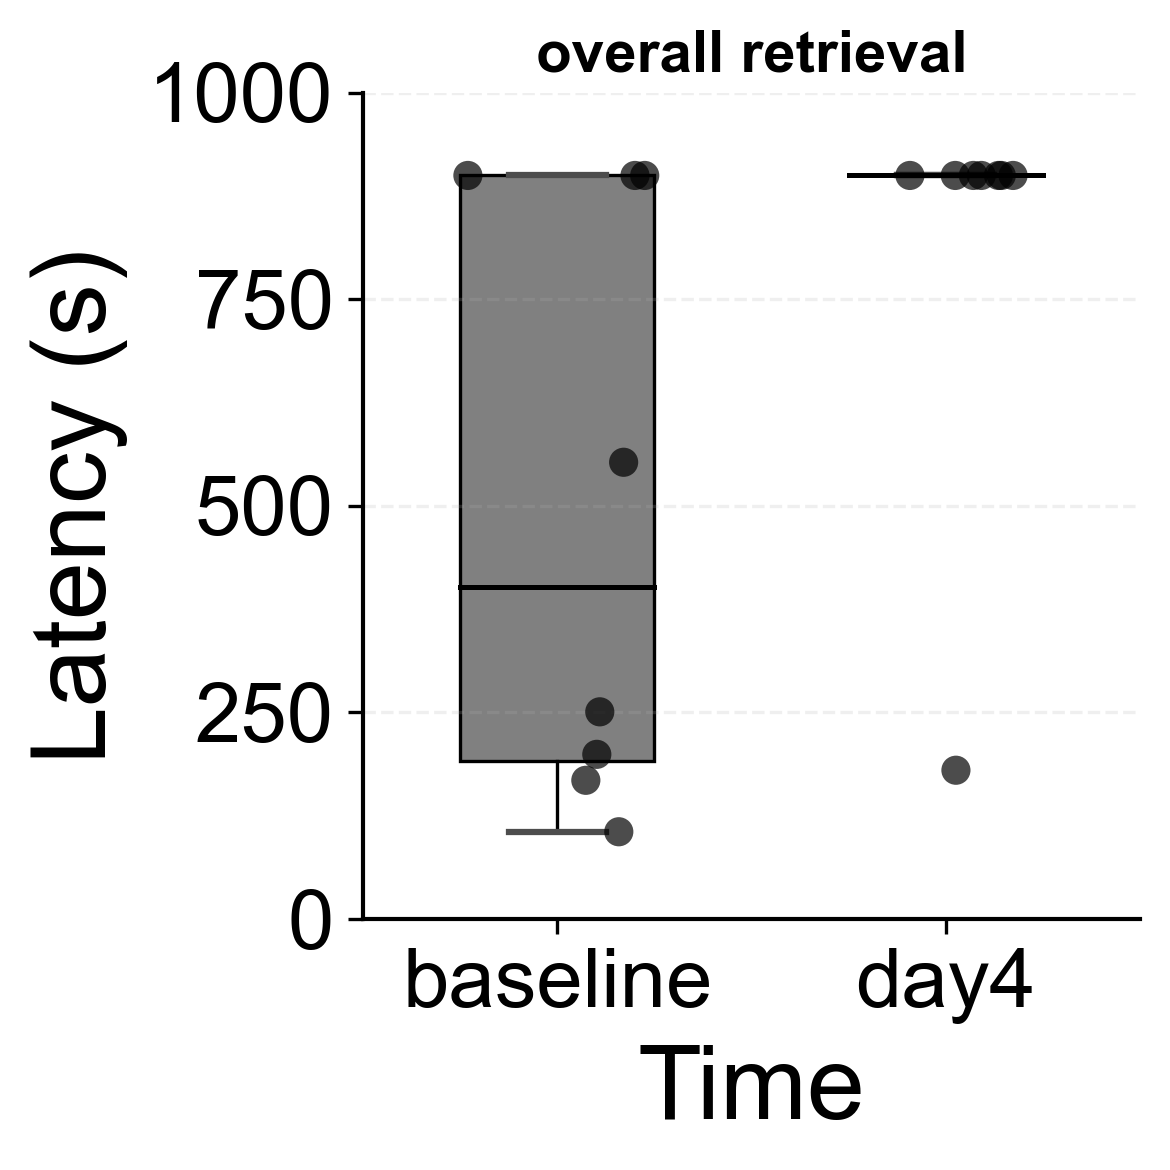

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/4028423617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


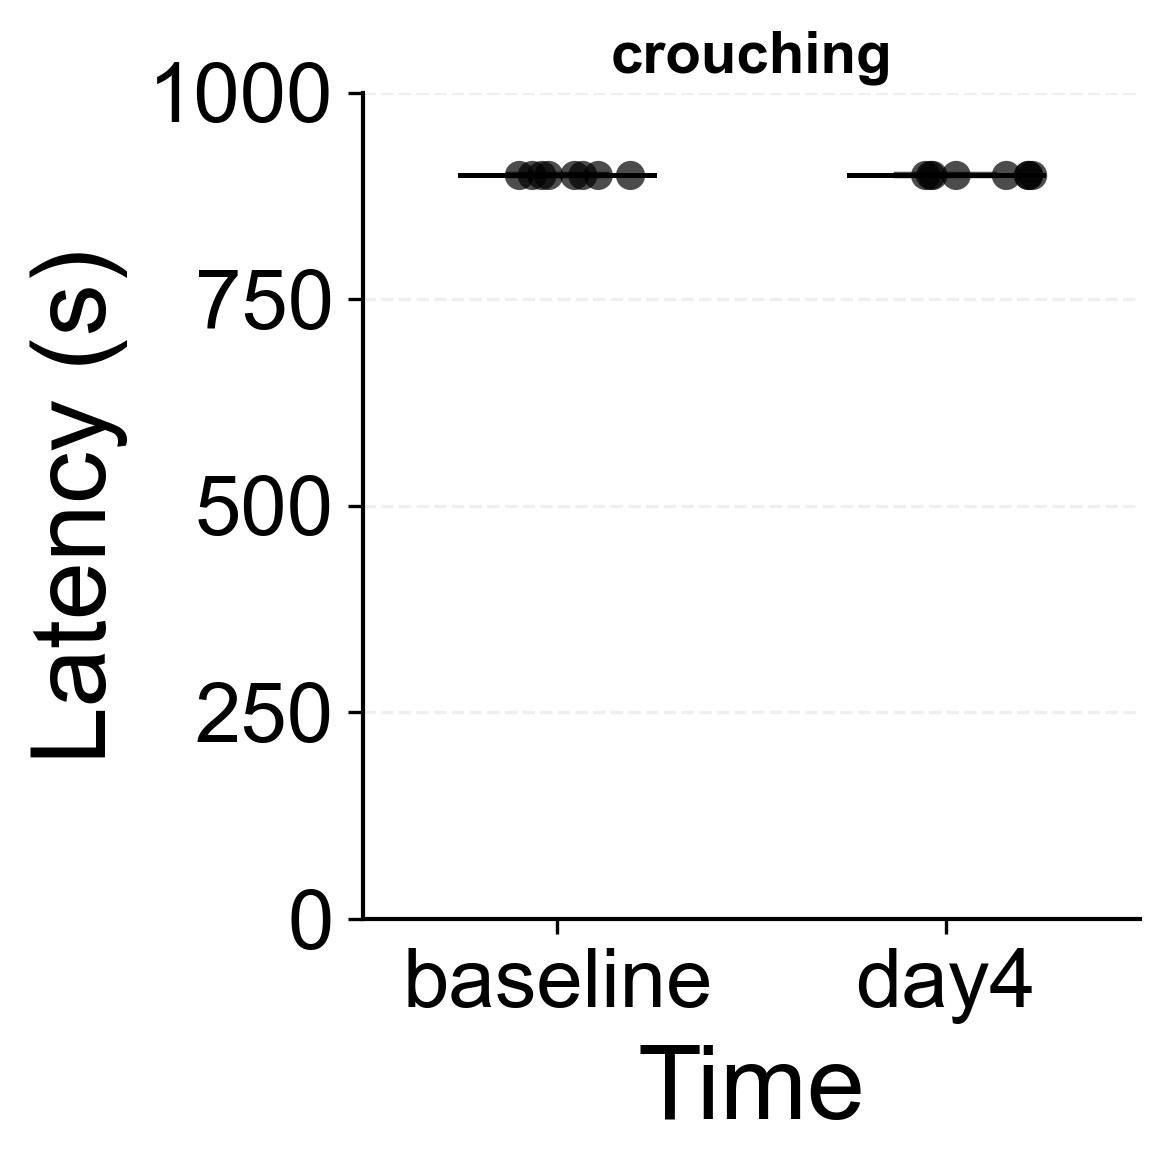

/var/folders/4g/5slcnh6x71lgn2r91zbk1pwr0000gn/T/ipykernel_35598/4028423617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behav_df.latency = pd.to_numeric(behav_df.latency)


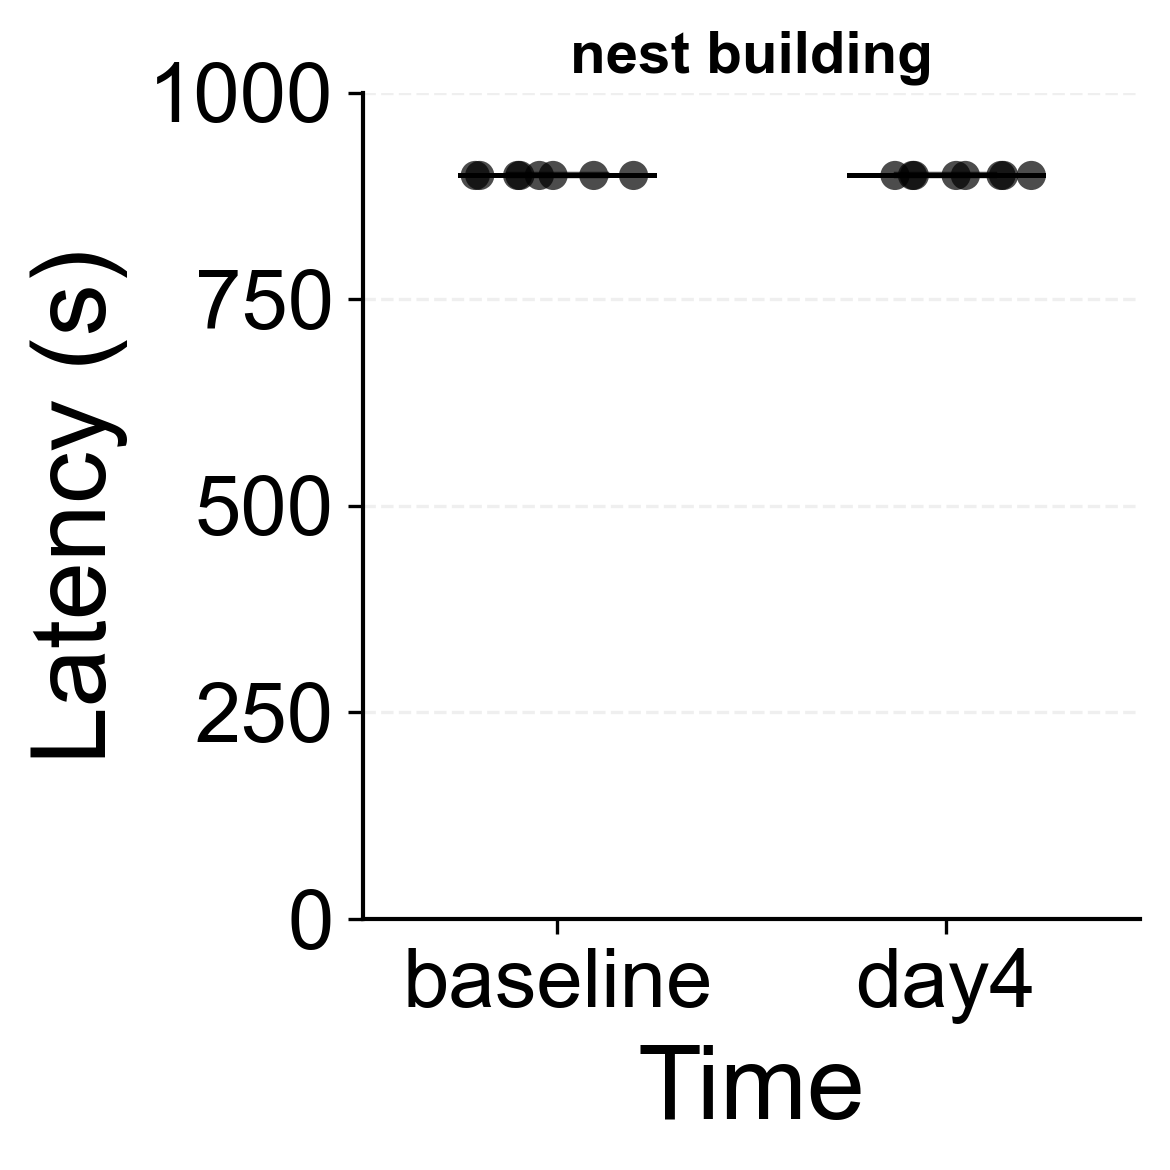

In [32]:
# Set publication-ready style parameters
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.linewidth': 1.0,
    'axes.labelsize': 25,
    'axes.titlesize': 14,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})

for behaviour in behaviours.behaviour.unique():
    behav_df = behaviours[behaviours.behaviour == behaviour]
    
    # Convert to numeric if needed
    behav_df.latency = pd.to_numeric(behav_df.latency)
    
    # Create figure with compact size
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Add a subtle grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    
    # Create an initial boxplot with custom styling
    box = sns.boxplot(x='time', y='latency', data=behav_df, 
                     palette=['#808080', '#a87dc2'],  # Light grey for baseline, purple for day4
                     width=0.5, 
                     boxprops={'edgecolor': 'black', 'linewidth': 0.8},
                     whiskerprops={'linewidth': 0.8, 'color': 'black'},
                     medianprops={'color': 'black', 'linewidth': 1.2},
                     showfliers=False)
    
    # Get all boxplot artists and adjust their alpha
    for i, artist in enumerate(ax.artists):
        # Apply alpha=0.7 to the day4 boxplot (second box)
        if i == 1:  # day4 boxplot
            artist.set_alpha(0.7)
    
    # Stripplot with black markers
    strip = sns.stripplot(x='time', y='latency', data=behav_df, 
                         color='black', alpha=0.7, size=7,
                         jitter=0.25, linewidth=0)
    
    # Set y-axis limits
    ax.set_ylim([0, 1000])
    
    # Adjust labels for compact size
    plt.ylabel('Latency (s)', labelpad=5)
    plt.xlabel('Time', labelpad=5)
    
    # Add title with minimal spacing
    plt.title(behaviour, pad=5, fontweight='bold')
    
    # Remove unnecessary spines
    sns.despine()
    
    # Ensure tight layout with minimal padding
    fig.tight_layout()
    
    # Save figures in publication-ready formats
    # plt.savefig(f'plots_mesh/{behaviour}_latency.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'plots_mesh/{behaviour}_latency.png', dpi=600, bbox_inches='tight')
    
    plt.show()

In [ ]:
for behaviour in behaviours.behaviour.unique():
    behav_df = behaviours[behaviours.behaviour == behaviour]
    
    plt.subplots(figsize = [10,6])
    sns.stripplot(x = "time", y = "duration", data = behav_df, palette = ["Tab:blue"], alpha = 0.7)
    plt.title(behaviour)
    sns.despine()
    plt.savefig(f'plots_mesh/{behaviour}_duration.jpg', dpi = 300, bbox_inches = 'tight')
    plt.show()

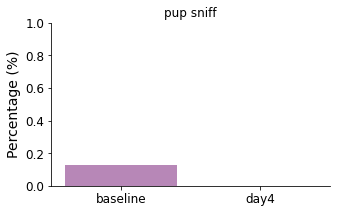

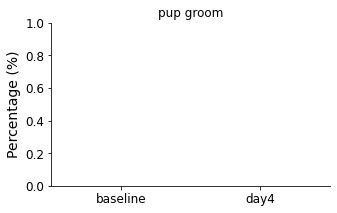

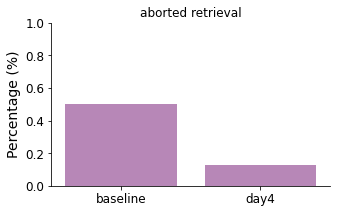

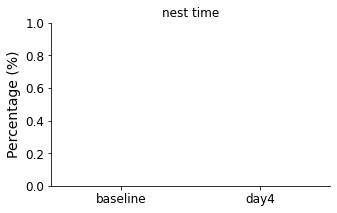

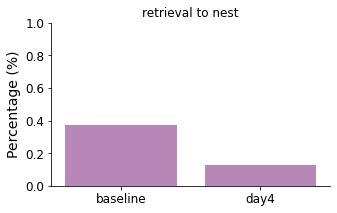

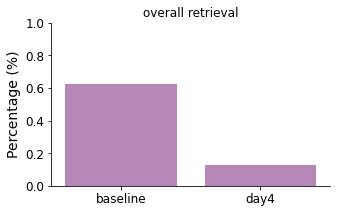

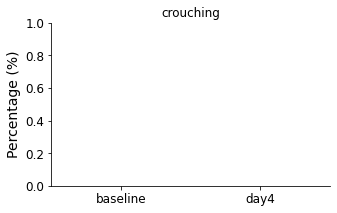

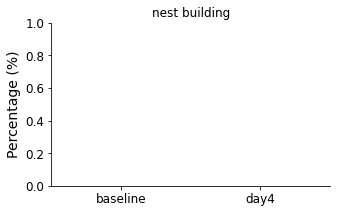

In [11]:
for behaviour in percentages.behaviour.unique():
    perc_df = percentages[percentages.behaviour == behaviour]
    
    plt.subplots(figsize = [5, 3])
    sns.barplot(x = "time", y = "percentage", data = perc_df, palette = ["purple"], alpha = 0.5)
    plt.title(behaviour)
    
    plt.ylim([0, 1])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.xlabel('')
    plt.ylabel('Percentage (%)',fontsize = 14)
    
    sns.despine()
    plt.savefig(f'plots_mesh/{behaviour}_percentage.jpg', dpi = 300)
    plt.show()

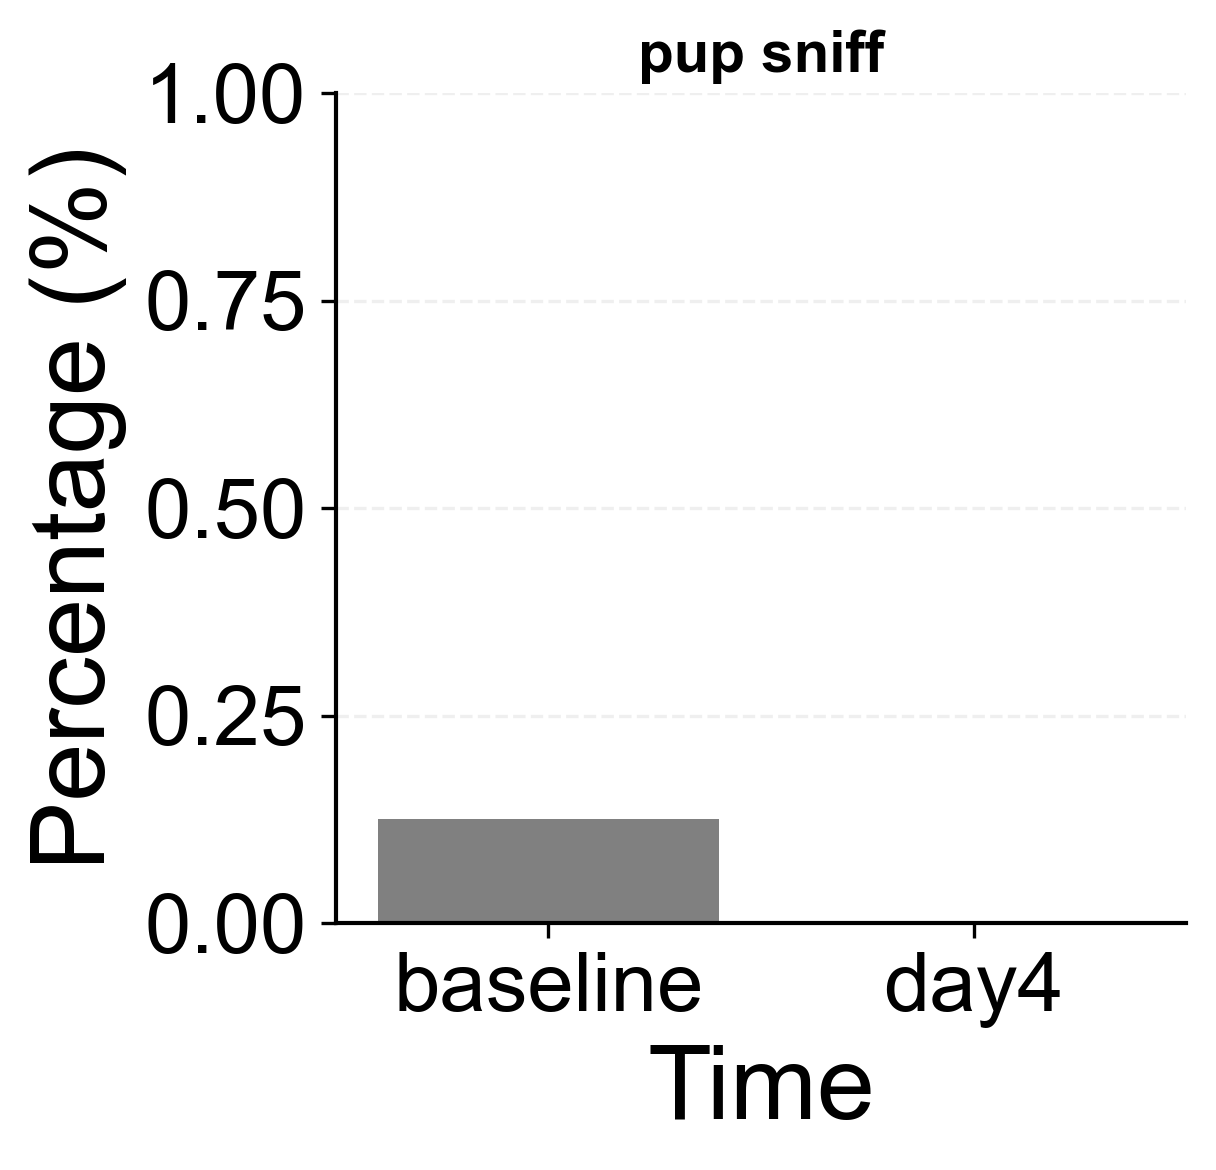

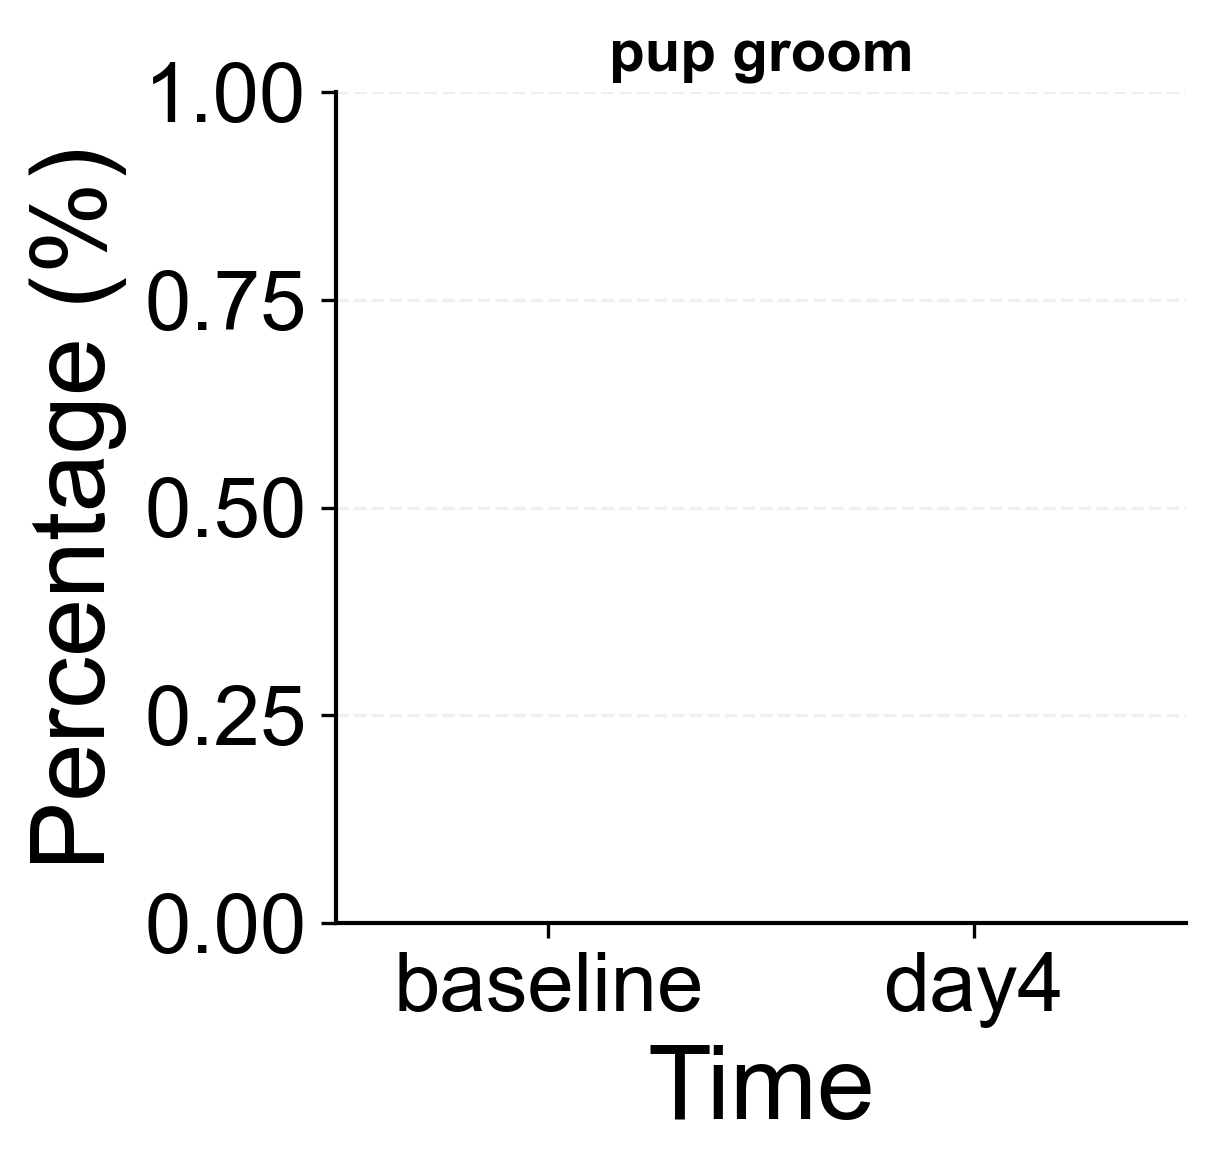

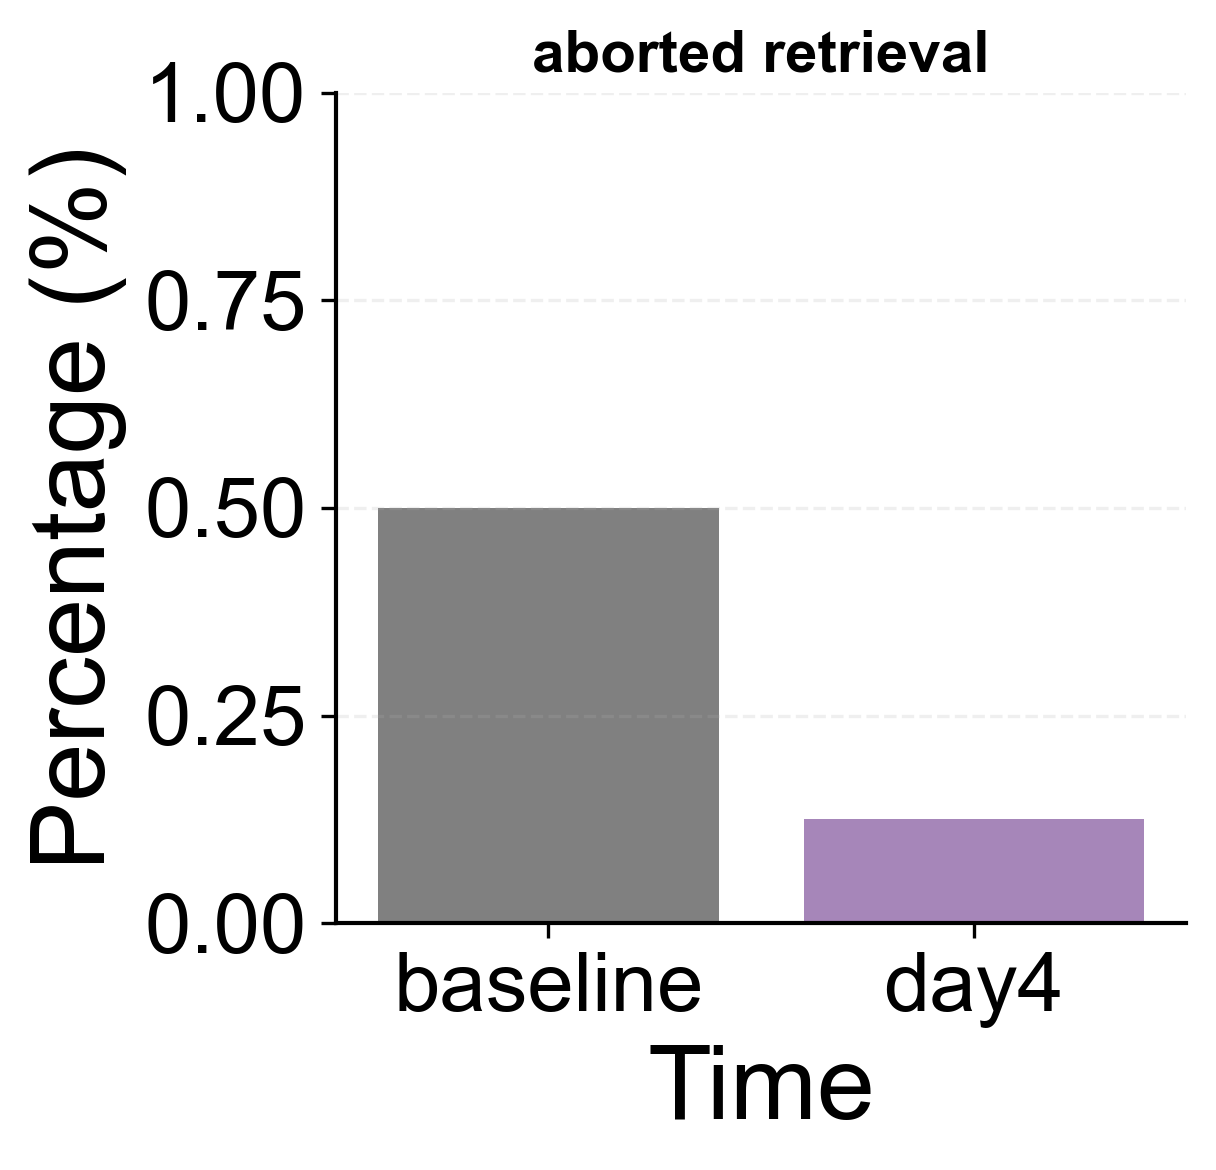

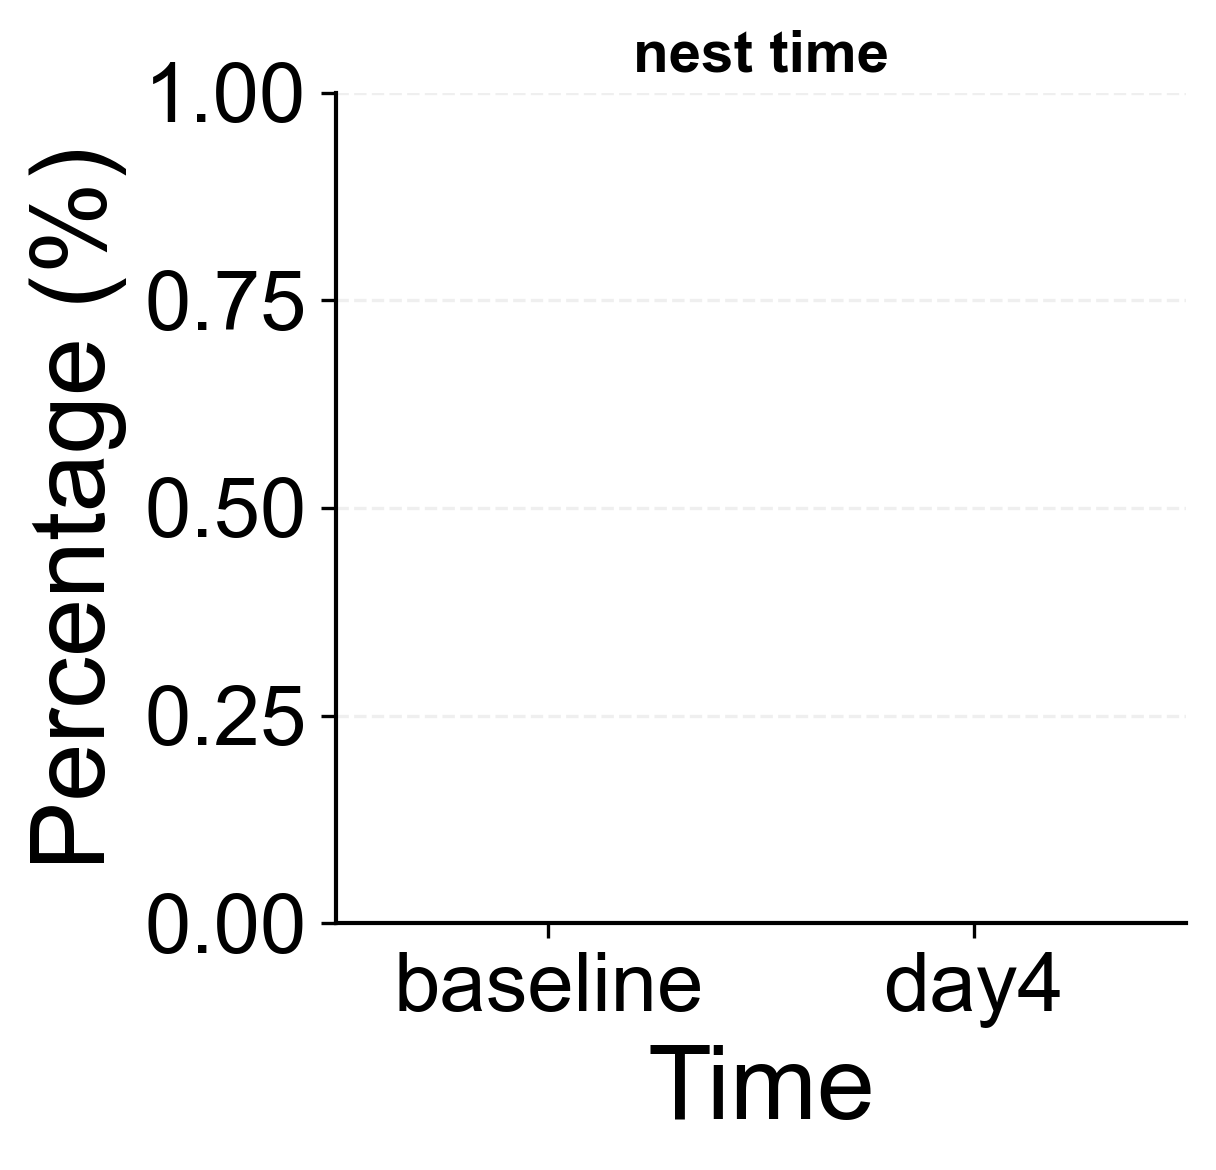

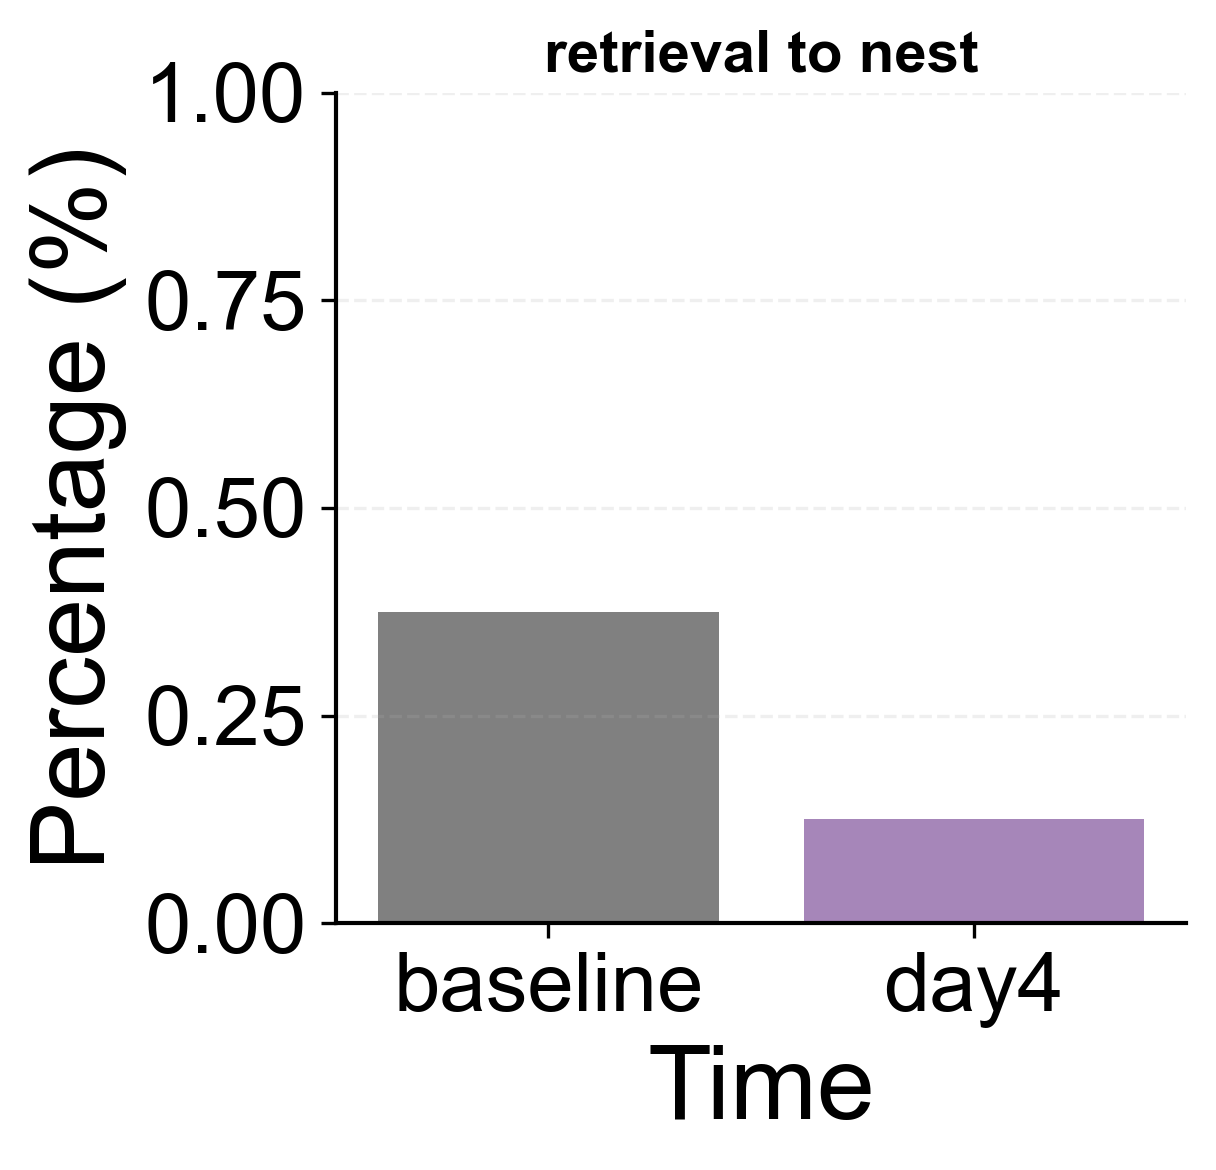

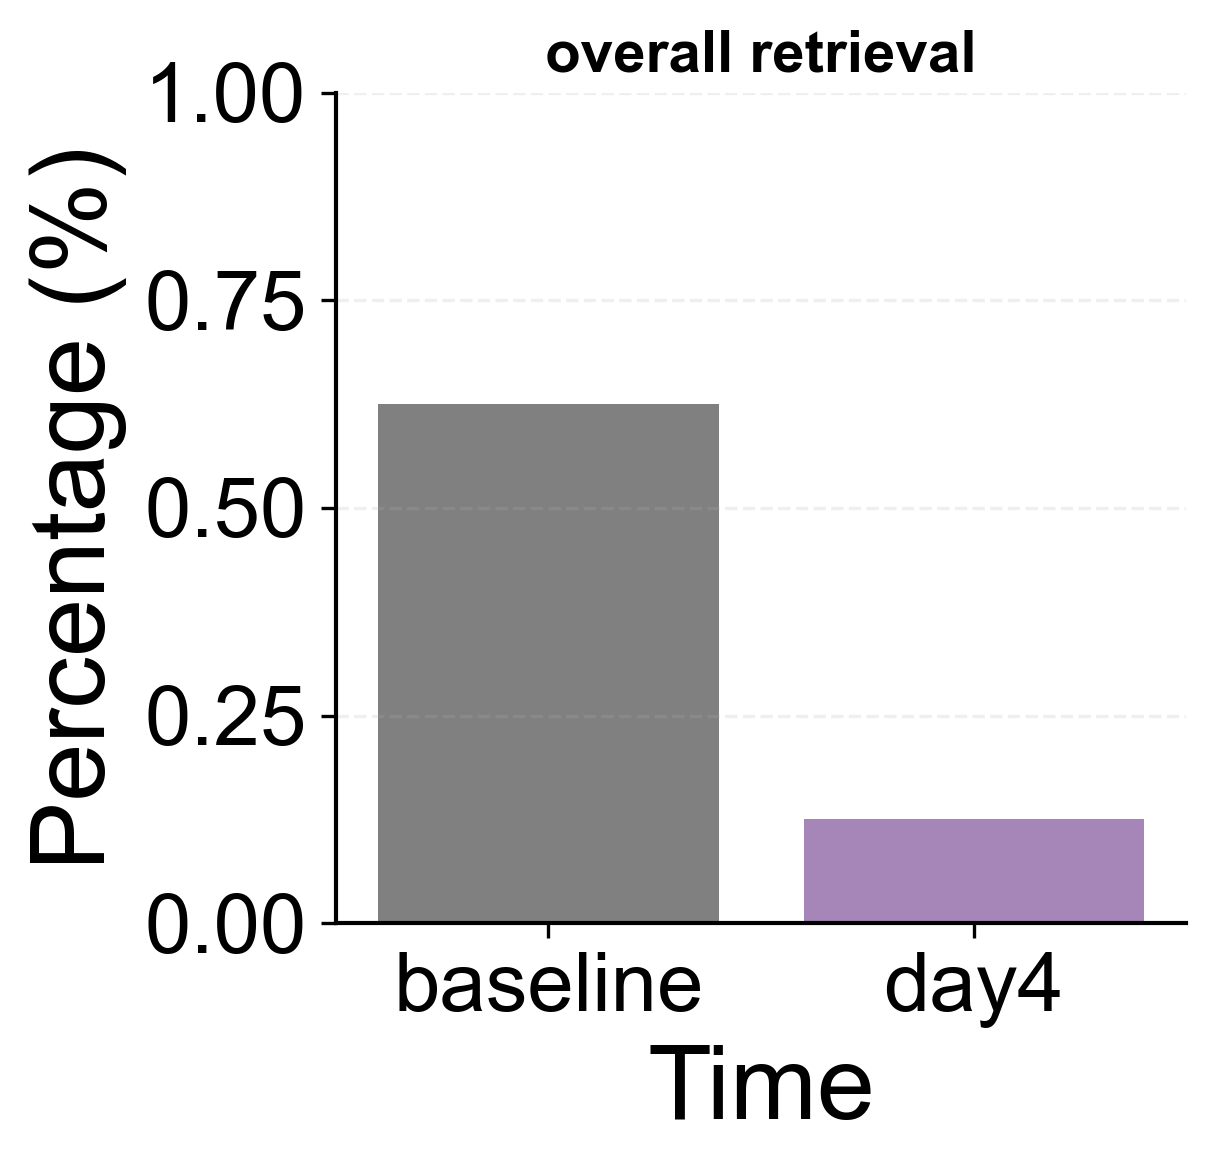

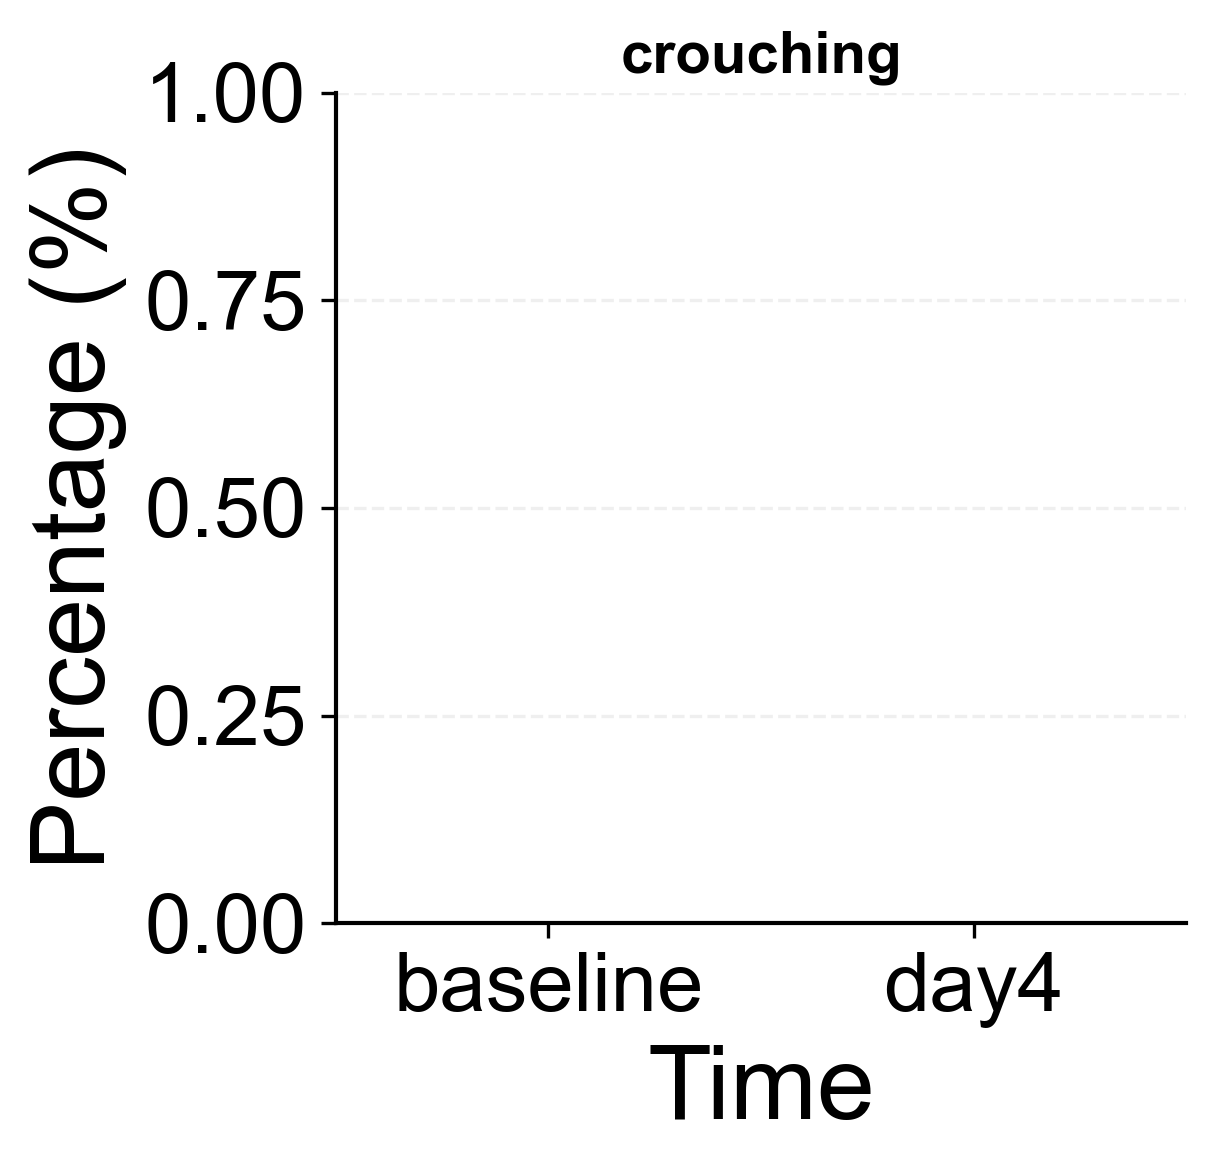

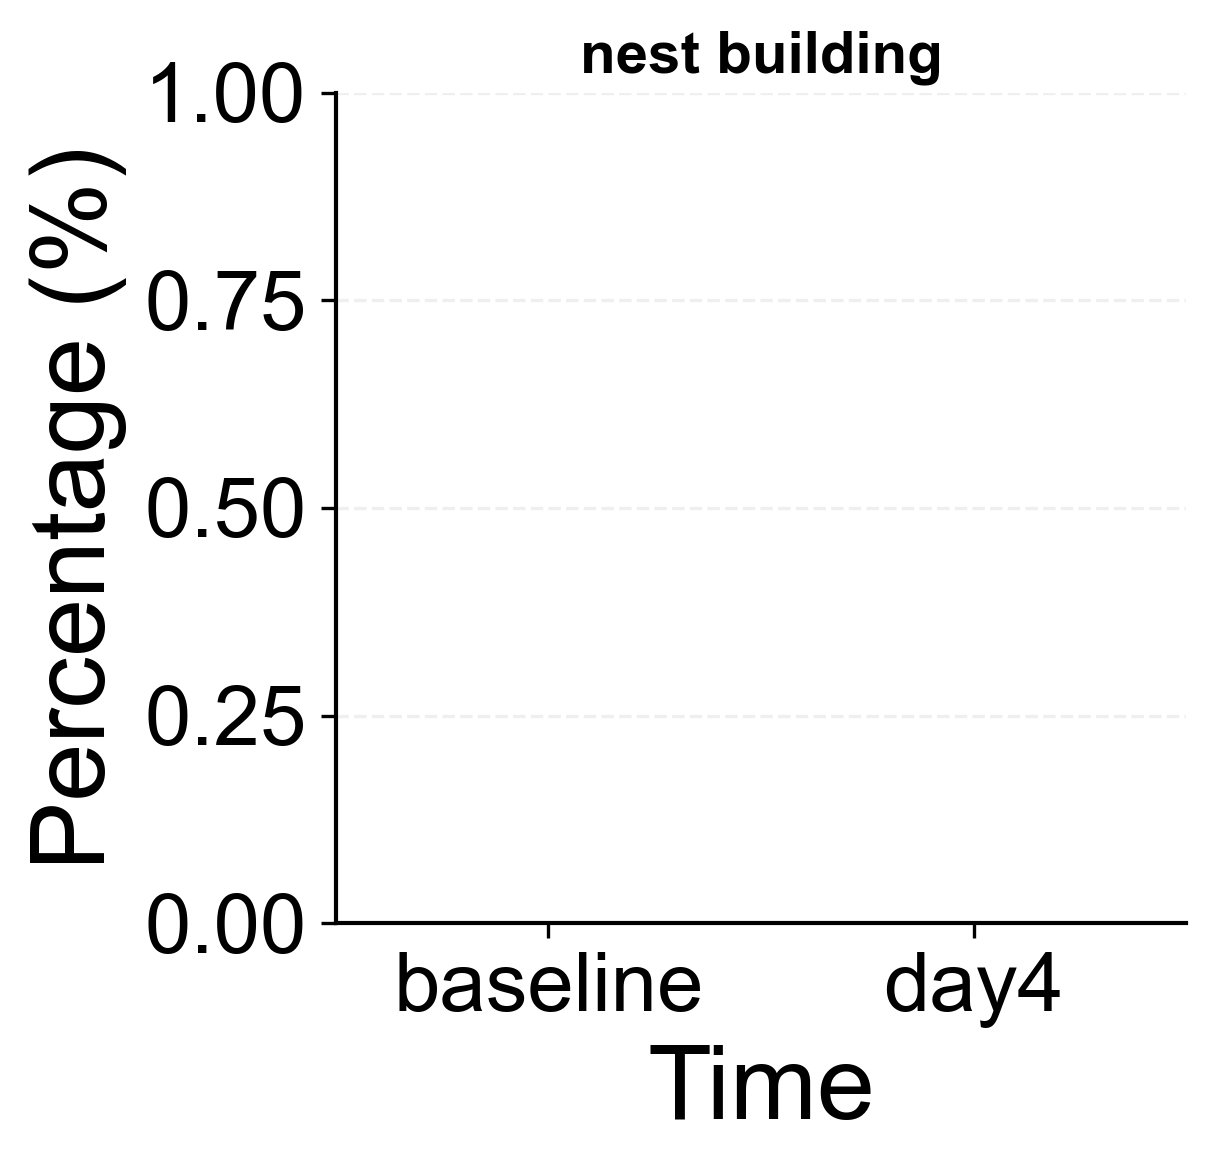

In [31]:
# Set publication-ready style parameters
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.linewidth': 1.0,
    'axes.labelsize': 25,
    'axes.titlesize': 14,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})

for behaviour in percentages.behaviour.unique():
    perc_df = percentages[percentages.behaviour == behaviour]
    
    # Create figure with compact size
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Add a subtle grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    
    # Enhanced barplot with better styling but keeping original color
    bar = sns.barplot(x="time", y="percentage", data=perc_df, 
                     palette=['#808080', '#a87dc2'], linewidth=0.8)
    
    # Set y-axis limits
    plt.ylim([0, 1])

    
    plt.xlabel('Time')
    plt.ylabel('Percentage (%)')
    
    # Add title with minimal spacing
    plt.title(behaviour, pad=5, fontweight='bold')
    
    # Remove unnecessary spines
    sns.despine()
    
    # Ensure tight layout with minimal padding
    fig.tight_layout()
    
    # Save figures in publication-ready formats
    plt.savefig(f'plots_mesh/{behaviour}_percentage.png', dpi=600, bbox_inches='tight')
    
    plt.show()